In [3]:
import os

os.getcwd()

'/home/jupyter'

In [2]:
os.chdir('/home/jupyter')

In [3]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.__config__.show())


True
12.1
PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.3.6 (Git Hash 86e6af5974177e513fd3fee58425e1063e7f1361)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86;-gencode;arch=compute_90,code=sm_90
  - CuDNN 8.9.2
  - Magma 2.6.1
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=12.1, CUDNN_VERSION=8.9.2, CXX_COMPILER=/opt/rh/devtoolset-9/root/usr/bin/c++, CXX_FLAGS= -D_GLIBCXX_USE_CXX11_ABI=0 -fabi-version=11 -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -DNDEBUG -

In [5]:
# # Run this in a Jupyter notebook cell
# !ls /usr/local/ | grep cuda


In [9]:
# # Check Symbolic Link Target:
# !ls -l /usr/local/cuda

lrwxrwxrwx 1 root root 20 Mar 24 08:14 /usr/local/cuda -> /usr/local/cuda-12.1


In [7]:
# # Examine Environment Variables
# !echo $CUDA_HOME
# !echo $PATH
# !echo $LD_LIBRARY_PATH


In [8]:
!nvidia-smi

Sun May  5 14:28:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:00:04.0 Off |                    0 |
| N/A   26C    P0              43W / 400W |      7MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [4]:
import torch

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA Version:", torch.version.cuda)
    print("CUDA Device Name:", torch.cuda.get_device_name(0))


PyTorch Version: 2.3.0+cu121
CUDA Available: True
CUDA Version: 12.1
CUDA Device Name: NVIDIA A100-SXM4-40GB


In [10]:
# # Set CUDA_HOME in your Jupyter notebook environment
# import os
# os.environ['CUDA_HOME'] = '/usr/local/cuda'

# # Verify that CUDA_HOME is set correctly
# print("CUDA_HOME:", os.environ['CUDA_HOME'])


In [3]:
# !python -m pip install --upgrade pip -q
# !pip install -q datasets
# !pip install -q git+https://github.com/huggingface/transformers.git@add-model-idefics
!pip install transformers -q -U
!pip install -q bitsandbytes sentencepiece accelerate loralib
!pip install -q -U git+https://github.com/huggingface/peft.git

In [4]:
import torch
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from PIL import Image
import transformers
from transformers import IdeficsForVisionText2Text, AutoProcessor, Trainer, TrainingArguments, BitsAndBytesConfig
import torchvision.transforms as transforms
import pandas as pd

In [5]:
# !pip freeze > requirements.txt

In [13]:
!nvcc --version

/bin/bash: line 1: nvcc: command not found


In [ ]:
# import sys

# # Install or upgrade jupyter and ipywidgets using the current Python executable
# !pip install --upgrade jupyter ipywidgets

# # Enable the widgetsnbextension using the current Python executable
# !jupyter nbextension enable --py widgetsnbextension

In [5]:
from huggingface_hub import notebook_login

notebook_login()

# Loading the model and the dataset

We load the model from the Hugging Face hub. idefics2-8b has gone through instruction fine-tuning on a large mixture of multimodal datasets and as such is a strong starting-point to fine-tune on your own use-case. We will start from this checkpoint.

In [6]:
# Enable fast weights download and upload
%env HF_HUB_ENABLE_HF_TRANSFER=1

env: HF_HUB_ENABLE_HF_TRANSFER=1


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# checkpoint = "HuggingFaceM4/tiny-random-idefics"
# checkpoint = "HuggingFaceM4/idefics-9b-instruct"
checkpoint = "HuggingFaceM4/idefics-9b-instruct"
# checkpoint = "HuggingFaceM4/idefics-80b-instruct"
# checkpoint = "idefics-80b-instruct"

# Here we skip some special modules that can't be quantized properly
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    # bnb_4bit_compute_dtype=torch.float16, #for non-ampere
    bnb_4bit_compute_dtype=torch.bfloat16,
    llm_int8_skip_modules=["lm_head", "embed_tokens"],
)

processor = AutoProcessor.from_pretrained(checkpoint)
# Simply take-off the quantization_config arg if you want to load the original model
model = IdeficsForVisionText2Text.from_pretrained(
    checkpoint,
    quantization_config=bnb_config,
    device_map="auto",
    cache_dir=''
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
print(model)

IdeficsForVisionText2Text(
  (model): IdeficsModel(
    (embed_tokens): IdeficsDecoupledEmbedding(
      num_embeddings=32000, num_additional_embeddings=3, embedding_dim=4096, partially_freeze=False
      (additional_embedding): Embedding(3, 4096)
    )
    (vision_model): IdeficsVisionTransformer(
      (embeddings): IdeficsVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(257, 1280)
      )
      (pre_layrnorm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (encoder): IdeficsVisionEncoder(
        (layers): ModuleList(
          (0-31): 32 x IdeficsVisionEncoderLayer(
            (self_attn): IdeficsVisionAttention(
              (k_proj): Linear4bit(in_features=1280, out_features=1280, bias=True)
              (v_proj): Linear4bit(in_features=1280, out_features=1280, bias=True)
              (q_proj): Linear4bit(in_features=1280, out_features=1280, bias=True)
        

In [10]:
print(processor)

IdeficsProcessor:
- image_processor: IdeficsImageProcessor {
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_num_channels": 3,
  "image_processor_type": "IdeficsImageProcessor",
  "image_size": 224,
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "IdeficsProcessor"
}

- tokenizer: LlamaTokenizerFast(name_or_path='HuggingFaceM4/idefics-9b-instruct', vocab_size=32000, model_max_length=2048, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<unk>', 'additional_special_tokens': ['<fake_token_around_image>', '<image>', '<end_of_utterance>']}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken

# Inference

Let's make a simple method to test the model's inference

In [9]:
# import matplotlib.pyplot as plt

# import numpy as np
# from PIL import Image
# import torchvision.transforms as transforms
# from transformers.image_transforms import center_crop

# class CenterCropTransform:
#     def __init__(self, size):
#         self.size = size  # Expected to be a tuple (width, height)

#     def __call__(self, image):
#         # Convert PIL Image to numpy array
#         image_np = np.array(image)

#         # Apply the center crop
#         cropped_image_np = center_crop(image=image_np, size=self.size)

#         # Convert numpy array back to PIL Image
#         cropped_image = Image.fromarray(cropped_image_np)

#         return cropped_image

# def convert_to_rgb(image):
#     # `image.convert("RGB")` would only work for .jpg images, as it creates a wrong background
#     # for transparent images. The call to `alpha_composite` handles this case
#     if image.mode == "RGB":
#         return image

#     image_rgba = image.convert("RGBA")
#     background = Image.new("RGBA", image_rgba.size, (255, 255, 255))
#     alpha_composite = Image.alpha_composite(background, image_rgba)
#     alpha_composite = alpha_composite.convert("RGB")
#     return alpha_composite

# def check_inference(model, processor, image, prompt_text, max_new_tokens=50, correct_caption='NOT SET'):
#     tokenizer = processor.tokenizer
#     bad_words = ["<image>", "<fake_token_around_image>"]
#     if len(bad_words) > 0:
#         bad_words_ids = tokenizer(bad_words, add_special_tokens=False).input_ids

#     image_size = processor.image_processor.image_size
#     image_mean = processor.image_processor.image_mean
#     image_std = processor.image_processor.image_std
    
#     # Define the image size for the center crop
#     image_dims = (image_size, image_size)  # Replace with the actual size you need
    
#     image_transform = transforms.Compose([
#         convert_to_rgb,
#         transforms.RandomResizedCrop((image_size, image_size), scale=(0.9, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
#         # Center crop is not working
#         # CenterCropTransform(image_dims),  # Use the custom center crop transform
#         transforms.ToTensor(),
#         transforms.Normalize(mean=image_mean, std=image_std),
#     ])
    
#     # eos_token = "</s>"
#     # eos_token_id = tokenizer.convert_tokens_to_ids(eos_token)

#     # Assuming the processor can handle the image directly
#     # If not, you'll need to preprocess the image as required by your processor
#     inputs = processor(
#         [image] + prompt_text,
#         # transform=image_transform,
#         return_tensors="pt"
#     ).to(device)
#     exit_condition = processor.tokenizer("<end_of_utterance>", add_special_tokens=False).input_ids
#     generated_ids = model.generate(**inputs, eos_token_id=exit_condition, bad_words_ids=bad_words_ids, max_new_tokens=max_new_tokens,
#                                    do_sample=False,
#                                    # early_stopping=True,
#                                   )
#     generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

#     # Display the image
#     plt.imshow(image)
#     plt.axis('off')  # Hide the axis
#     plt.show()

#     # Print the generated text
#     print(generated_text)

#     print(f"\nCorrect caption: {correct_caption}")

In [9]:
import matplotlib.pyplot as plt
import re
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from transformers.image_transforms import center_crop

class CenterCropTransform:
    def __init__(self, size):
        self.size = size  # Expected to be a tuple (width, height)

    def __call__(self, image):
        # Convert PIL Image to numpy array
        image_np = np.array(image)

        # Apply the center crop
        cropped_image_np = center_crop(image=image_np, size=self.size)

        # Convert numpy array back to PIL Image
        cropped_image = Image.fromarray(cropped_image_np)

        return cropped_image

def convert_to_rgb(image):
    # `image.convert("RGB")` would only work for .jpg images, as it creates a wrong background
    # for transparent images. The call to `alpha_composite` handles this case
    if image.mode == "RGB":
        return image

    image_rgba = image.convert("RGBA")
    background = Image.new("RGBA", image_rgba.size, (255, 255, 255))
    alpha_composite = Image.alpha_composite(background, image_rgba)
    alpha_composite = alpha_composite.convert("RGB")
    return alpha_composite

def check_inference(model, processor, image, prompt_text, max_new_tokens=100):
    tokenizer = processor.tokenizer
    bad_words = ["<image>", "<fake_token_around_image>"]
    if len(bad_words) > 0:
        bad_words_ids = tokenizer(bad_words, add_special_tokens=False).input_ids

    image_size = processor.image_processor.image_size
    image_mean = processor.image_processor.image_mean
    image_std = processor.image_processor.image_std
    
    # Define the image size for the center crop
    image_dims = (image_size, image_size)  # Replace with the actual size you need
    
    image_transform = transforms.Compose([
        convert_to_rgb,
        transforms.RandomResizedCrop((image_size, image_size), scale=(0.9, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
        # Center crop is not working
        # CenterCropTransform(image_dims),  # Use the custom center crop transform
        transforms.ToTensor(),
        transforms.Normalize(mean=image_mean, std=image_std),
    ])
    
    # eos_token = "</s>"
    # eos_token_id = tokenizer.convert_tokens_to_ids(eos_token)

    # Assuming the processor can handle the image directly
    # If not, you'll need to preprocess the image as required by your processor
    ## Process the image
    # processed_image = image_transform(image)
    
    inputs = processor(
        [image] + prompt_text,
        # transform=image_transform,
        return_tensors="pt"
    ).to(device)
    exit_condition = processor.tokenizer("<end_of_utterance>", add_special_tokens=False).input_ids
    generated_ids = model.generate(**inputs, eos_token_id=exit_condition, bad_words_ids=bad_words_ids, max_new_tokens=max_new_tokens,
                                   do_sample=False,
                                   # early_stopping=True,
                                  )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    
    # Clean the generated text
    clean_text = re.sub(r'<.*?>', '', generated_text)  # Removes tokens in angle brackets
    # clean_text = re.sub(r'User: What do you see in this picture\?\s*\\nAssistant: ', '', clean_text, flags=re.IGNORECASE)  # Removes the prompt
    return clean_text.strip()

In [ ]:
# from PIL import Image, ExifTags

# # Load the image
# # image_path = "whitequeen_misplaced.JPEG"
# image_path = "knight_and_rook.jpg"
# image = Image.open(image_path)

# # Check if the image has EXIF data and rotate accordingly
# try:
#     for orientation in ExifTags.TAGS.keys():
#         if ExifTags.TAGS[orientation] == 'Orientation':
#             break
#     exif = dict(image._getexif().items())

#     if exif[orientation] == 3:
#         image = image.rotate(180, expand=True)
#     elif exif[orientation] == 6:
#         image = image.rotate(270, expand=True)
#     elif exif[orientation] == 8:
#         image = image.rotate(90, expand=True)
# except (AttributeError, KeyError, IndexError):
#     # Cases: image doesn't have getexif
#     pass

# # Display the corrected image
# image.show()

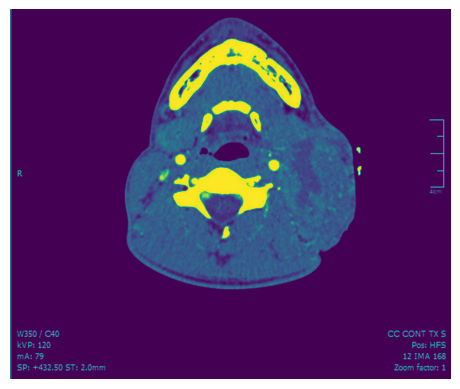

<s><fake_token_around_image><image><fake_token_around_image> User: What do you see in this picture?<end_of_utterance> 
Assistant: The image shows a CT scan of a person's head. The scan reveals a large mass in the brain, which is causing swelling and pressure on the brain. The mass is located in the center of the brain, occupying a significant portion of the brain tissue. The scan also shows a large vein, which is likely contributing to the swelling. The person is currently undergoing treatment for this condition.<end_of_utterance>

Correct caption: NOT SET


In [10]:
from PIL import Image

# Path to your image file
image_path = 'ImageCLEFmedical_Caption_2024_valid_000012.jpg'

# Open the image with PIL
image = Image.open(image_path)

prompts = [
    "User: What do you see in this picture?",
    f"\nAssistant: "
]
check_inference(model, processor, image, prompts, max_new_tokens=100)


# Finetuning dataset
Prepare the dataset that will be used for finetuning

In [10]:
def ds_transforms(example_batch):
    image_size = processor.image_processor.image_size
    image_mean = processor.image_processor.image_mean
    image_std = processor.image_processor.image_std
    
    # Define the image size for the center crop
    image_dims = (image_size, image_size)  # Replace with the actual size you need
    
    image_transform = transforms.Compose([
        convert_to_rgb,
        # transforms.RandomResizedCrop((image_size, image_size), scale=(0.9, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
        CenterCropTransform(image_dims),  # Use the custom center crop transform
        transforms.ToTensor(),
        transforms.Normalize(mean=image_mean, std=image_std),
    ])

    prompts = []
    for i in range(len(example_batch['caption'])):
        # We split the captions to avoid having very long examples, which would require more GPU ram during training
        caption = example_batch['caption'][i].split(".")[0]
        prompts.append(
            [
                example_batch['image'][i],
                "User: What do you see in this picture?",
                f"\nAssistant: {example_batch['caption'][i]}",
            ],
        )

    inputs = processor(
        prompts,
        # transform=image_transform,
        return_tensors="pt"
    ).to(device)

    inputs["labels"] = inputs["input_ids"]

    return inputs


# load and prepare dataset
ds = load_dataset("HoqueMahmudul/clef2024_train_valid_a")

train_ds = ds["train"]
eval_ds = ds["test"]
train_ds.set_transform(ds_transforms)
eval_ds.set_transform(ds_transforms)

# Print a sample

CT chest axial view showing a huge ascending aortic aneurysm (*).


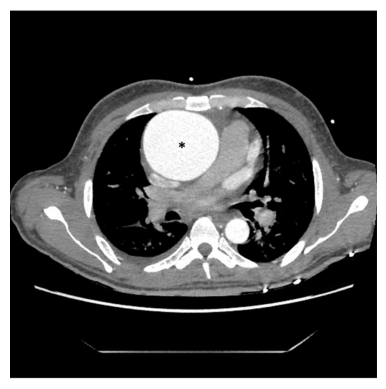

In [12]:
# Temporarily disable the transformation to access the original data
eval_ds.reset_format()

# Now access the original caption for the 0th row
print(eval_ds[0]['caption'])

import matplotlib.pyplot as plt

# Access the image for the 0th element
image = eval_ds[0]['image']

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# Re-enable the transformation if needed
eval_ds.set_transform(ds_transforms)

# LoRA

After specifying the low-rank adapters (LoRA) config, we load the PeftModel using the get_peft_model utility function

In [39]:
# print(model)

#### Attention Projection Layers:
Query, Key, and Value Projections (q_proj, k_proj, v_proj): These layers in both the vision model's attention mechanisms and the text decoder's cross-attention mechanisms are prime candidates. They directly influence how the model attends to different parts of the input (both visual features and textual context), which is crucial for generating relevant and coherent captions.


#### Output Projections:
Output Projection (out_proj): This layer transforms the attended features back into the space of the model's internal representations, which then feed into further processing layers or output layers. Adapting this part can refine how attention results are integrated and used for generating the next parts of the text.

In [11]:
model_name = checkpoint.split("/")[1]
config = LoraConfig(
    r=16,# Rank of the adaptation matrices
    lora_alpha=32,# Scaling factor for adaptation
    target_modules=["q_proj", "k_proj", "v_proj", "out_proj"],
    lora_dropout=0.05, # Dropout rate for the adapted layers
    bias="none", # Whether to adapt bias terms
)
model = get_peft_model(model, config)

In [12]:
model.print_trainable_parameters()

trainable params: 21,061,632 || all params: 8,950,749,456 || trainable%: 0.23530579314653538


# Pre-Training Evaluation

In [ ]:
!pip install matplotlib -q -U

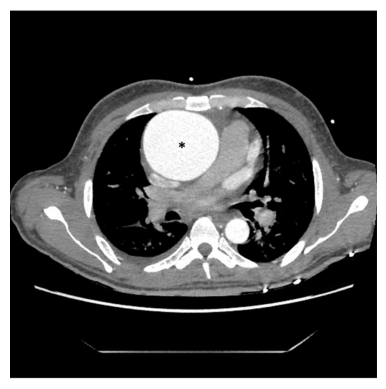

<s><fake_token_around_image><image><fake_token_around_image> User: What do you see in this picture?<end_of_utterance> 
Assistant: The image displays a CT scan of a person's chest. The scan shows a large mass in the chest cavity, which appears to be a tumor. The mass is located in the upper part of the chest, occupying a significant portion of the space. The surrounding tissues, including the lungs and ribs, are also visible in the image. The image is in black and white, and the contrast is high, making the details of the mass and surrounding t

Correct caption: CT chest axial view showing a huge ascending aortic aneurysm (*).


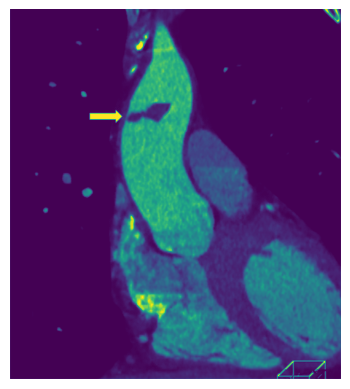

<s><fake_token_around_image><image><fake_token_around_image> User: What do you see in this picture?<end_of_utterance> 
Assistant: The image shows a chest X-ray of a patient with a foreign object in the chest. The foreign object is located in the middle of the chest, and it appears to be a metallic object. The X-ray shows the object's shadow on the chest, indicating its presence. The patient is lying on a bed, and the X-ray is taken from the side view.<end_of_utterance>

Correct caption: Computed tomography (CT) shows floating thrombosis (white arrow)


In [13]:
# Temporarily disable the transformation to access the original data
eval_ds.reset_format()

i = 0
# Iterate over each example in the evaluation dataset
for i in range(len(eval_ds)):
    # Access the original image and caption for the current row
    image = eval_ds[i]['image']
    caption = eval_ds[i]['caption']

    # Create the prompt as specified
    prompt = [
        "User: What do you see in this picture?",
        f"\nAssistant: "
    ]

    # Run the inference check
    check_inference(model, processor, image, prompt, 100, caption)
    i += 1
    if i == 2:
        break

# Re-enable the transformation if needed
eval_ds.set_transform(ds_transforms)

# Training

Finally, using the Hugging Face Trainer, we can finetune the model!

For the sake of the demo, we have set the max_steps at 40. That's about 0.05 epoch on this dataset, so feel free to tune further!

It has been reported that fine-tuning in mixed precision fp16 can lead to overflows. As such, we recommend training in mixed precision bf16 when possible.

In [13]:
import pandas as pd
from transformers import TrainerCallback, EarlyStoppingCallback

In [14]:
# Define a custom callback
class PrintBestCheckpointCallback(TrainerCallback):
    def on_train_end(self, args, state, control, **kwargs):
        # Print the path of the best checkpoint at the end of training
        print(f"Best model checkpoint: {state.best_model_checkpoint}")

In [18]:
# clear chache to empty memory

# torch.cuda.empty_cache()

In [15]:
training_args = TrainingArguments(
    output_dir=f"/home/jupyter/Models/{model_name}-2cuda-r16-params 21,061,632",
    learning_rate=1e-4,
    # fp16=True, #for non ampere gpus
    bf16=True,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    dataloader_pin_memory=False,
    save_total_limit=25,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=500,
    eval_steps=500,
    logging_steps=10,
    num_train_epochs=2,
    # max_steps=40,
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["labels"],
    load_best_model_at_end=True,
    report_to=None,
    optim="adamw_torch",
)

# Initialize your custom callback
print_best_checkpoint_callback = PrintBestCheckpointCallback()

# Initialize early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=1,  # Number of evaluation steps with no improvement after which training will be stopped
    early_stopping_threshold=0.5  # Minimum change needed to qualify as an improvement
)

# Initialize the list of callbacks you want to use
# Combine custom callback with the early stopping callback
callbacks = [print_best_checkpoint_callback, early_stopping_callback]

/opt/conda/envs/llava1.5env/lib/python3.8/site-packages/transformers/training_args.py:1463: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    callbacks=callbacks,
)

trainer.train('/home/jupyter/Models/idefics-9b-instruct-2cuda-r16-params 21,061,632/checkpoint-6500')

[2024-05-12 05:01:19,559] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cvandinfo-2024 (https-www-morgan-edu). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
7000,1.113100,1.181684


Best model checkpoint: /home/jupyter/Models/idefics-9b-instruct-2cuda-r16-params 21,061,632/checkpoint-7000


TrainOutput(global_step=7000, training_loss=0.08193965135301863, metrics={'train_runtime': 4477.0097, 'train_samples_per_second': 31.319, 'train_steps_per_second': 1.957, 'total_flos': 4.3009472077357075e+17, 'train_loss': 0.08193965135301863, 'epoch': 1.5977063958464084})

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    callbacks=callbacks,
)

trainer.train()

[2024-05-09 18:07:33,091] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cvandinfo-2024 (https-www-morgan-edu). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
500,1.241100,1.268967
1000,1.188200,1.250208
1500,1.200700,1.237598
2000,1.233700,1.225798
2500,1.235800,1.218886
3000,1.272000,1.212244
3500,1.205900,1.208361
4000,1.218300,1.202238


# Eval after Training

In [ ]:
# # check generation again after finetuning
# check_inference(model, processor, prompts, max_new_tokens=100)

In [17]:
# # Temporarily disable the transformation to access the original data
# eval_ds.reset_format()

# image_size = processor.image_processor.image_size
# image_mean = processor.image_processor.image_mean
# image_std = processor.image_processor.image_std

# # Iterate over each example in the evaluation dataset
# for i in range(len(eval_ds)):
#     # Access the original image and caption for the current row
#     image = eval_ds[i]['image']
#     caption = eval_ds[i]['caption']

#     # Create the prompt as specified
#     prompt = [
#         "User: What do you see in this picture?",
#         f"\nAssistant: "
#     ]

#     # Run the inference check
#     check_inference(model, processor, image, prompt, 250, caption)

# # Re-enable the transformation if needed
# eval_ds.set_transform(ds_transforms)

## Check trainer state

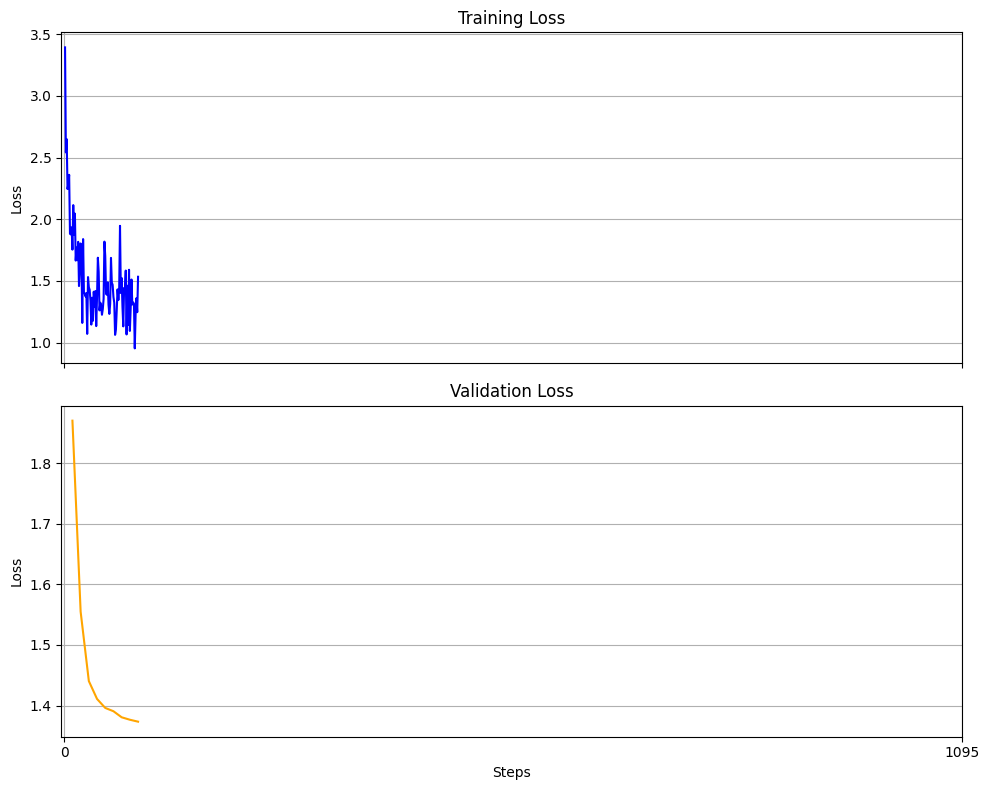

In [18]:
import json
import matplotlib.pyplot as plt

# Load the training history
with open('/home/jupyter/Models/idefics-9b-instruct-testtrain/checkpoint-90/trainer_state.json', 'r') as file:
    trainer_state = json.load(file)

# Extract loss values from the trainer_state
training_steps = []
training_losses = []
validation_steps = []
validation_losses = []

for log_entry in trainer_state['log_history']:
    if 'loss' in log_entry and 'step' in log_entry:  # This is a training loss entry
        training_steps.append(log_entry['step'])
        training_losses.append(log_entry['loss'])
    elif 'eval_loss' in log_entry and 'step' in log_entry:  # This is a validation loss entry
        validation_steps.append(log_entry['step'])
        validation_losses.append(log_entry['eval_loss'])

# Set up the plot
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot training loss
ax[0].plot(training_steps, training_losses, label='Training Loss', color='blue')
ax[0].set_title('Training Loss')
ax[0].set_ylabel('Loss')
ax[0].grid(True)

# Plot validation loss
ax[1].plot(validation_steps, validation_losses, label='Validation Loss', color='orange')
ax[1].set_title('Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Steps')
ax[1].grid(True)

# Define the tick values as multiples of 1095, considering the range of your steps
tick_step = 1095
xticks = range(0, max(max(training_steps, default=0), max(validation_steps, default=0)) + tick_step, tick_step)
ax[1].set_xticks(xticks)  # Set x-ticks on both subplots

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Generate CSV

In [17]:
# Example usage with a dataset
ds_test = load_dataset("HoqueMahmudul/test_dataset")

test_ds = ds_test['test']

In [ ]:
import pandas as pd

# Temporarily disable the transformation to access the original data
test_ds.reset_format()

image_size = processor.image_processor.image_size
image_mean = processor.image_processor.image_mean
image_std = processor.image_processor.image_std

def clean_caption(caption):
    # print("Original Caption:", caption)
    # Match the prompt more robustly with different whitespace patterns
    cleaned_caption = re.sub(r'User: What do you see in this picture\?\s*Assistant: ', '', caption, flags=re.IGNORECASE)
    # print("Cleaned Caption:", cleaned_caption)
    return cleaned_caption.strip()


# Prepare a list to store the results
results = []

# Iterate over each example in the evaluation dataset
for i in range(len(test_ds)):
    # Access the original image and caption for the current row
    image = test_ds[i]['image']
    image_name = test_ds[i]['image_name']

    # Create the prompt as specified
    prompt = [
        "User: What do you see in this picture?",
        f"\nAssistant: "
    ]

    # Run the inference check
    generated_caption = check_inference(model, processor, image, prompt, 50)
    
    # Clean the generated caption
    clean_generated_caption = clean_caption(generated_caption)
    
    # Store the results
    results.append({
        'Image Name': image_name,
        'Caption': clean_generated_caption
    })

# Convert results to a DataFrame
df_captions = pd.DataFrame(results)

# # Display the DataFrame to verify the contents
# print(df_captions)

# Save the DataFrame to a CSV file
df_captions.to_csv('/home/jupyter/Test dataset caption/idefics_9B_r16-params 21,061,632.csv', index=False)    
    
# Re-enable the transformation if needed
test_ds.set_transform(ds_transforms)

In [40]:
import pandas as pd

results

[{'Image Name': 'ImageCLEFmedical_Caption_2024_test_000001.jpg',
  'Caption': 'Fluoroscopic image of the left common carotid artery showing the position of the microcatheter (yellow arrow) and the microcoils (white arrows) in the left internal carotid artery. The'},
 {'Image Name': 'ImageCLEFmedical_Caption_2024_test_000002.jpg',
  'Caption': 'Fluoroscopic image of the left hip joint. The yellow arrow shows the needle tip in the femoral head. The white arrow shows the needle tip in the acetabulum. The black arrow shows the needle'},
 {'Image Name': 'ImageCLEFmedical_Caption_2024_test_000003.jpg',
  'Caption': 'Endoscopic retrograde cholangiopancreatography (ERCP) showing a dilated common bile duct with a filling defect in the distal common bile duct. The filling defect was identified as a stone.'},
 {'Image Name': 'ImageCLEFmedical_Caption_2024_test_000004.jpg',
  'Caption': 'Endoscopic retrograde cholangiopancreatography (ERCP) showing a dilated common bile duct with a filling defect.

In [41]:
df_captions = pd.DataFrame(results)

df_captions.to_csv('/home/jupyter/Test dataset caption/idefics_9B_testtrain.csv', index=False)  

In [38]:
results

[{'Image Name': 'ImageCLEFmedical_Caption_2024_test_000001.jpg',
  'Caption': 'Fluoroscopic image of the left common carotid artery showing the position of the microcatheter (yellow arrow) and the microcoils (white arrows) in the left internal carotid artery. The'},
 {'Image Name': 'ImageCLEFmedical_Caption_2024_test_000002.jpg',
  'Caption': 'Fluoroscopic image of the left hip joint. The yellow arrow shows the needle tip in the femoral head. The white arrow shows the needle tip in the acetabulum. The black arrow shows the needle'},
 {'Image Name': 'ImageCLEFmedical_Caption_2024_test_000003.jpg',
  'Caption': 'Endoscopic retrograde cholangiopancreatography (ERCP) showing a dilated common bile duct with a filling defect in the distal common bile duct. The filling defect was identified as a stone.'},
 {'Image Name': 'ImageCLEFmedical_Caption_2024_test_000004.jpg',
  'Caption': 'Endoscopic retrograde cholangiopancreatography (ERCP) showing a dilated common bile duct with a filling defect.

In [30]:
df_captions = pd.DataFrame(results)

In [32]:
df_captions
# Save the DataFrame to a CSV file
df_captions.to_csv('/home/jupyter/Test dataset caption/idefics_9B_r16-params 21,061,632.csv', index=False)  

In [36]:
results

[{'Image Name': 'ImageCLEFmedical_Caption_2024_test_000001.jpg',
  'Caption': 'User: Can you describe in a single sentence what you see in this picture? \nAssistant: Fluoroscopic image of the left common carotid artery showing the position of the microcatheter (yellow arrow) and the microcoils (white arrows) in the left internal carotid artery. The'},
 {'Image Name': 'ImageCLEFmedical_Caption_2024_test_000002.jpg',
  'Caption': 'User: Can you describe in a single sentence what you see in this picture? \nAssistant: Fluoroscopic image of the left hip joint. The yellow arrow shows the needle tip in the femoral head. The white arrow shows the needle tip in the acetabulum. The black arrow shows the needle'},
 {'Image Name': 'ImageCLEFmedical_Caption_2024_test_000003.jpg',
  'Caption': 'User: Can you describe in a single sentence what you see in this picture? \nAssistant: Endoscopic retrograde cholangiopancreatography (ERCP) showing a dilated common bile duct with a filling defect in the dis

In [ ]:
# Temporarily disable the transformation to access the original data
test_ds.reset_format()

image_size = processor.image_processor.image_size
image_mean = processor.image_processor.image_mean
image_std = processor.image_processor.image_std

# Iterate over each example in the evaluation dataset
for i in range(len(test_ds)):
    # Access the original image and caption for the current row
    image = test_ds[i]['image']
    image_name = test_ds[i]['image_name']

    # Create the prompt as specified
    prompt = [
        "User: What do you see in this picture?",
        f"\nAssistant: "
    ]
    
    # Append the correct and predicted captions as a tuple to the captions list
    captions.append((image_name, predicted_caption))

# Create a DataFrame from the captions list with the specified column titles
df_captions_generation_test = pd.DataFrame(captions, columns=['ID', 'Caption'])

# Display the DataFrame to verify the contents
print(df_captions_generation_test)

# Optionally, save the DataFrame to a CSV file
df_captions_generation_test.to_csv('/home/jupyter/Test dataset caption/idefics_9B_testtrain.csv', index=False)

# Re-enable the transformation if needed
test_ds.set_transform(lambda batch: tokenize_and_create_labels(batch, image_processor, tokenizer, model, device))

# Push your new model to the hub!

In [ ]:
# Required when quantizing models/data that are gated on HuggingFace, and required for pushing models to HuggingFace.
!pip install huggingface_hub -q -U
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
model=model.merge_and_unload()

In [ ]:
model.push_to_hub(f"HoqueMahmudul/idefics_9B", private=True)

In [ ]:
tokenizer.push_to_hub(f"HoqueMahmudul/idefics_9B", private=True)

# Finished!!

In [6]:
# Three options for training, from the lowest precision training to the highest precision training:
# - QLoRA
# - Standard LoRA
# - Full fine-tuning

if USE_QLORA or USE_LORA:
    lora_config = LoraConfig(
        r=16,
        lora_alpha=32,
        lora_dropout=0.1,
        target_modules='.*(text_model|modality_projection|perceiver_resampler).*(down_proj|gate_proj|up_proj|k_proj|q_proj|v_proj|o_proj).*$',
        use_dora=False if USE_QLORA else True,
        init_lora_weights="gaussian",
        use_rslora=True,
    )
    model.add_adapter(lora_config)
    model.enable_adapters()
else:
    print("No adapters being added for full fine-tuning")

In [ ]:
# try out left padding, can lead to better responses
processor.tokenizer.padding_side = "left"

In [10]:
# # trainable paramter

# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.shape)


In [15]:
total_params = 0
trainable_params = 0

for param in model.parameters():
    total_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()

print(f"Trainable parameters: {trainable_params}")
print(f"Total parameters: {total_params}")


# Calculate the percentage of trainable parameters
if total_params > 0:  # To avoid division by zero
    percentage_trainable = (trainable_params / total_params) * 100
else:
    percentage_trainable = 0

print(f"Percentage of trainable parameters: {percentage_trainable:.2f}%")


Trainable parameters: 48192256
Total parameters: 8450960368
Percentage of trainable parameters: 0.57%


## Load Dataset

In [19]:
# # HF example dataset. Note that you need to select the english query - see dataset prep below.
# from datasets import load_dataset

# train_dataset = load_dataset("nielsr/docvqa_1200_examples", split="train")
# train_dataset = train_dataset.remove_columns(['id', 'words', 'bounding_boxes', 'answer'])

# eval_dataset = load_dataset("nielsr/docvqa_1200_examples", split="test")
# eval_dataset = eval_dataset.remove_columns(['id', 'words', 'bounding_boxes', 'answer'])

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/200 [00:00<?, ? examples/s]

In [48]:
from datasets import load_dataset

# load and prepare dataset
ds = load_dataset("HoqueMahmudul/test")

train_dataset = ds["train"]
eval_dataset = ds["test"]

In [49]:
train_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=762x527>,
 'caption': 'Grade 4: over three-quarters of the endometrial length occupied by blood or debris.'}

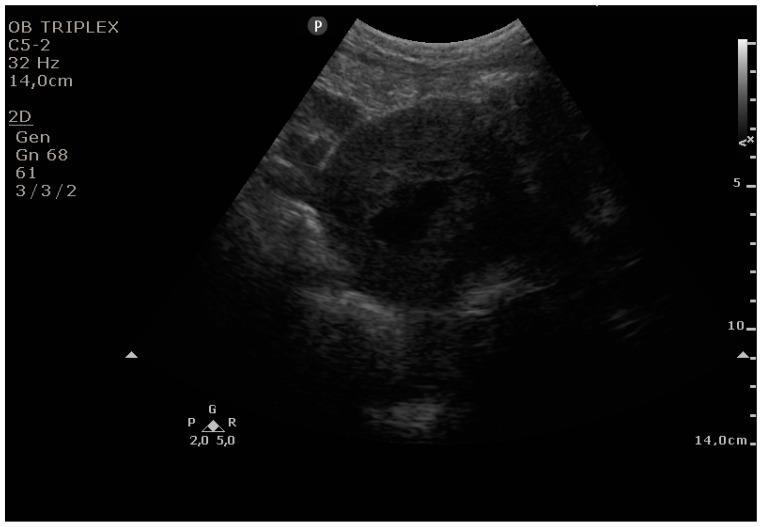

In [50]:
train_dataset[0]["image"]

## Evaluation before Training

In [28]:
import torch
from PIL import Image
from torchvision.transforms.functional import to_pil_image, resize

def run_model_evaluation(dataset, num_samples=None, device='cuda', constant_query=None):
    model.eval()
    results = []

    # Limit the dataset if a specific number of samples is provided
    if num_samples is not None:
        dataset = torch.utils.data.Subset(dataset, range(num_samples))

    for example in dataset:
        image = example["image"]
        if constant_query is None:
            query = example["query"]["en"]
        else:
            query = constant_query  # Use the constant query if provided

        # Display a reduced size version of the image
        pil_image = image
        aspect_ratio = pil_image.width / pil_image.height
        new_width = 300
        new_height = int(new_width / aspect_ratio)
        display_image = resize(pil_image, (new_height, new_width))
        display_image.show()  # This will open the image in the default image viewer

        # Construct the message template
        messages = [
            {
                "role": "user",
                "content": [
                    # {"type": "text", "text": "Answer briefly."},
                    # {"type": "image"}, # ADD A SECOND IMAGE!!! Note that the text must be "image" for every image.
                    {"type": "image"}, # YOU CAN COMMENT THIS OUT IF THERE ARE NO IMAGES.
                    {"type": "text", "text": query}
                ]
            }
        ]

        # Apply the chat template to preprocess input
        text = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(text=[text.strip()], images=[image], return_tensors="pt", padding=True).to(device)
        # inputs = processor(text=[text.strip()], images=[image1,image2], return_tensors="pt", padding=True).to(device) ## ADD A SECOND IMAGE!!!

        # Generate output from the model
        generated_ids = model.generate(**inputs, max_new_tokens=64)
        generated_texts = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)

        print(f"Prediction: {generated_texts[0]}\n")
        
        results.append(generated_texts[0])  # Store the result

    return results

In [51]:
# Usage
eval_results = run_model_evaluation(eval_dataset, num_samples=3, device='cuda', constant_query="What do you see in this picture?")
# print(eval_results)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/var/tmp/tmpct36xlpr.PNG'


Prediction: The image shows a pregnancy sac in the abdomen of the patient.



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/var/tmp/tmph8qdru7h.PNG'


Prediction: The left kidney is not visible. the right kidney is small and located in the right iliac fossa. there is a large, well-circumscribed, hypoechoic mass arising from the right kidney.



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/var/tmp/tmp8w89wifs.PNG'


Prediction: This is a chest x ray of a patient with left lobe mass lesion.



# Other Sample

The example below shows how you can feed in zero, one or two images to the evaluation.

For no images, you can pass images=None into the processor. You can see how this is automatically handled below.

You can also train on multiple images using this approach, by adjusting the datacollator below in the same manner as is done for evaluation here. Note that you'll need to update your dataset so that it has a column for second (and subsequent images) and ensure they are passed correctly within the data collator.

In [40]:
# image1 = "/home/jupyter/ImageCLEFmedical_Caption_2024_test_000001.jpg"
# image2 = "/home/jupyter/ImageCLEFmedical_Caption_2024_valid_000012.jpg"

# # Choose between one of the following.
# images = [image1, image2]
# # images = [image1]         # Example with one image
# # images = None             # Example with no images


# # Message content creation
# messages = [
#     {
#         "role": "user",
#         "content": [
#             {"type": "image"},  # For first image
#             {"type": "image"},  # For second image
#             {"type": "text", "text": "How many images do you see and what is in each?"}
#         ]
#     }
# ]

# # Formatting and processing the message
# text = processor.apply_chat_template(messages, add_generation_prompt=True)
# print(f"formatted prompt: {text}")

# # Ensure the structured images match the expected format by the processor
# inputs = processor(
#     text=[text.strip()],
#     images=images,  # Single flat list of images corresponding directly to <image> tags
#     return_tensors="pt",
#     padding=True).to('cuda')

# # Generate output from the model
# generated_ids = model.generate(**inputs, max_new_tokens=64)
# generated_texts = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)

# print(f"Prediction: {generated_texts[0]}\n")


## Manual Evaluation on an image - With Image Splitting

In [47]:
import torch
from PIL import Image
from torchvision.transforms.functional import to_pil_image, resize

def evaluate_image(image_path, model, processor, device='cuda'):
    model.eval()
    
    # Open the image directly from the path
    pil_image = Image.open(image_path).convert('RGB')  # Convert to RGB for consistency

    # Resize the image for display (optional, for visualization)
    aspect_ratio = pil_image.width / pil_image.height
    new_width = 600
    new_height = int(new_width / aspect_ratio)
    display_image = resize(pil_image, (new_height, new_width))
    display_image.show()  # Display the resized image

    # Construct the message template
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": "What do you see in the picture?"}
            ]
        }
    ]

    # Apply the chat template to preprocess input
    text = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(
        text=[text.strip()], 
        images=[pil_image], 
        return_tensors="pt", 
        padding=True
    ).to(device)

    # Generate output from the model
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_texts = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)

    print(f"Prediction: {generated_texts[0]}")
    return generated_texts[0]

# Example usage
image_path = "/home/jupyter/ImageCLEFmedical_Caption_2024_test_000001.jpg"
result = evaluate_image(image_path, model, processor)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/var/tmp/tmpj849tkgz.PNG'


Prediction: This is a image of an angiogram.


## Training loop

We first define the data collator which takes list of samples and return input tensors fed to the model. There are 4 tensors types we are interested:

input_ids: these are the input indices fed to the language model
attention_mask: the attention mask for the input_ids in the language model
pixel_values: the (pre-processed) pixel values that encode the image(s). Idefics2 treats images in their native resolution (up to 980) and their native aspect ratio
pixel_attention_mask: when multiple image(s) are packed into the same sample (or in the batch), attention masks for the images are necessary because of these images can have different sizes and aspect ratio. This masking ensures that the vision encoder properly forwards the images.

In [54]:
import random

class MyDataCollator:
    def __init__(self, processor):
        self.processor = processor
        self.image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")
        ]

    def __call__(self, examples):
        texts = []
        images = []
        for example in examples:
            image = example["image"]
            question = 'What do you see in this picture?'
            # question = example["query"]["en"] # for hf dataset
            answer = example["caption"] # for chess dataset
            # answer = random.choice(example["answers"]) # for hf dataset
            messages = [
                {
                    "role": "user",
                    "content": [
                        # {"type": "text", "text": "Answer briefly."},
                        {"type": "image"},
                        {"type": "text", "text": question}
                    ]
                },
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": answer}
                    ]
                }
            ]
            text = processor.apply_chat_template(messages, add_generation_prompt=False)
            texts.append(text.strip())
            images.append([image])

        batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

        labels = batch["input_ids"].clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.image_token_id
        batch["labels"] = labels

        return batch

data_collator = MyDataCollator(processor)

In [ ]:
# # SAMPLE CODE FOR HOW YOU MIGHT DO MULTIPLE IMAGES (OR NO IMAGES)
# import random

# class MyDataCollator:
#     def __init__(self, processor):
#         self.processor = processor
#         self.image_token_id = processor.tokenizer.additional_special_tokens_ids[
#             processor.tokenizer.additional_special_tokens.index("<image>")
#         ]

#     def __call__(self, examples):
#         texts = []
#         images = []
#         for example in examples:
#             example_images = [example["image"]] #for just one image column in your dataset
#             # example_images =  [example["image1"], example["image2"]] # if you want two images
            
#             question = 'What do you see here?' # for chess dataset

#             answer = example["caption"] # for chess dataset

#             messages = []
            
#             # Add images
#             if example_images is not None:
#                 message_content = [{"type": "image"} for _ in example_images]
#                 message_content.append({"type": "text", "text": "How many images do you see and what is in each?"})
#             else:
#                 message_content = [{"type": "text", "text": "How are you today?"}]
            
#             # Add the composed message
#             messages.append({
#                 "role": "user",
#                 "content": message_content
#             })
#             text = processor.apply_chat_template(messages, add_generation_prompt=False)
#             texts.append(text.strip())
#             images.append(example_images)

#         batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

#         labels = batch["input_ids"].clone()
#         labels[labels == processor.tokenizer.pad_token_id] = self.image_token_id
#         batch["labels"] = labels

#         return batch

# data_collator = MyDataCollator(processor)

##### Warmup

Avoiding Early Overfitting: Starting with a too high learning rate when your model begins training on a very small dataset might lead to rapid overfitting before the learning rate can appropriately adjust.

Stabilizing Training: For larger datasets, using warmup steps allows the model to start learning gently, preventing drastic updates that might destabilize training dynamics.

In [55]:
from transformers import TrainerCallback, EarlyStoppingCallback

In [56]:
# Define a custom callback
class PrintBestCheckpointCallback(TrainerCallback):
    def on_train_end(self, args, state, control, **kwargs):
        # Print the path of the best checkpoint at the end of training
        print(f"Best model checkpoint: {state.best_model_checkpoint}")

In [61]:
!pip install --upgrade transformers accelerate


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 2.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.21.0
    Uninstalling accelerate-0.21.0:
      Successfully uninstalled accelerate-0.21.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llava 1.2.2.post1 requires accelerate==0.21.0, but you have accelerate 0.30.0 which is incompatible.
llava 1.2.2.post1 requires tokenizers==0.15.1, but you have tokenizers 0.19.1 which is incompatible.
llava 1.2.2.post1 requires transformers==4.37.2, but you have transformers 4.41.0.dev0 which is incompatible.


In [62]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    # max_steps=1,
    num_train_epochs=2,
    per_device_train_batch_size=5,
    per_device_eval_batch_size=5,
    gradient_accumulation_steps=5,
    warmup_steps=50, #Enable warmup steps for larger datasets
    learning_rate=1e-5, #setting a bit lower as rs_lora is being used
    weight_decay=0.01,
    logging_steps=1,
    output_dir="/home/jupyter/Models/Idefics-test",
    evaluation_strategy="steps",
    eval_steps=5,
    save_strategy="steps",
    save_steps=5,
    save_total_limit=5,
    # evaluation_strategy="epoch",
    # fp16=True, #if 
    bf16=True,
    hub_model_id="HoqueMahmudul/idefics2-test",
    remove_unused_columns=False,
    # report_to="wandb",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",  # validation loss this is the metric I am monitoring
    greater_is_better=False,  # indicate that lower values of the monitored metric (eval loss) are better
    gradient_checkpointing=True, #should reduce VRAM requirements a lot
    gradient_checkpointing_kwargs={'use_reentrant':True}
)

# Initialize your custom callback
print_best_checkpoint_callback = PrintBestCheckpointCallback()

# Initialize early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,  # Number of evaluation steps with no improvement after which training will be stopped
    early_stopping_threshold=0.01  # Minimum change needed to qualify as an improvement
)

# Initialize the list of callbacks you want to use
# Combine custom callback with the early stopping callback
callbacks = [print_best_checkpoint_callback, early_stopping_callback]

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset, # You can also evaluate (loss) on the eval set, note that it will incur some additional GPU memory
    #callbacks=callbacks,
)

TypeError: __init__() got an unexpected keyword argument 'use_seedable_sampler'

In [63]:
trainer.train()

NameError: name 'trainer' is not defined

# Evaluation
Let's evaluate the model. Looking at a qualitative generation from the model.

In [ ]:
eval_results = run_model_evaluation(eval_dataset, num_samples=3, device='cuda', constant_query="What do you see here?")

## Push it hub

In [ ]:
trainer.push_to_hub()


# OCR Type evaluation
During the training, we tracked the loss on the evaluation split. It is interesting to measure the performance using the "true metric" used for DocVQA.

The metric at hand is the Average Normalized Levenshtein Similarity (ANLS). The Average Normalized Levenshtein Similarity (ANLS) proposed by Biten+ ICCV'19 smoothly captures the OCR mistakes applying a slight penalization in case of correct intended responses, but badly recognized. It also makes use of a threshold of value 0.5 that dictates whether the output of the metric will be the ANLS if its value is equal or bigger than 0.5 or 0 otherwise. The key point of this threshold is to determine if the answer has been correctly selected but not properly recognized, or on the contrary, the output is a wrong text selected from the options and given as an answer.

We first define a few utilities to compute the ANLS.

In [53]:
!pip install Levenshtein -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
import Levenshtein

def normalized_levenshtein(s1, s2):
    len_s1, len_s2 = len(s1), len(s2)
    distance = Levenshtein.distance(s1, s2)
    return distance / max(len_s1, len_s2)

def similarity_score(a_ij, o_q_i, tau=0.5):
    nl = normalized_levenshtein(a_ij, o_q_i)
    return 1 - nl if nl < tau else 0

def average_normalized_levenshtein_similarity(ground_truth, predicted_answers):
    assert len(ground_truth) == len(predicted_answers), "Length of ground_truth and predicted_answers must match."

    N = len(ground_truth)
    total_score = 0

    for i in range(N):
        a_i = ground_truth[i]
        o_q_i = predicted_answers[i]
        if o_q_i == "":
            print("Warning: Skipped an empty prediction.")
            max_score = 0
        else:
            max_score = max(similarity_score(a_ij, o_q_i) for a_ij in a_i)

        total_score += max_score

    return total_score / N

In [ ]:
# Some gpu mem cleaning before inferencing eval. necessary because we are in memory constrained env
torch.cuda.empty_cache()

In [ ]:
from tqdm import tqdm

EVAL_BATCH_SIZE = 1

answers_unique = []
generated_texts_unique = []

EVAL_BATCH_SIZE = 1

for i in tqdm(range(0, len(eval_dataset), EVAL_BATCH_SIZE)):
    examples = eval_dataset[i: i + EVAL_BATCH_SIZE]
    # answers_unique.extend(examples["answers"])
    answers_unique.extend(examples["caption"])
    images = [[im] for im in examples["image"]]
    texts = []
    # for q in examples["query"]:
    #     messages = [
    #         {
    #             "role": "user",
    #             "content": [
    #                 # {"type": "text", "text": "Answer briefly."},
    #                 {"type": "image"},
    #                 # {"type": "text", "text": q["en"]}
    #                 {"type": "text", "text": q}
    #             ]
    #         }
    #     ]
    #     text = processor.apply_chat_template(messages, add_generation_prompt=True)
    #     texts.append(text.strip())

    hardcoded_query = "What do you see in this picture?"

    messages = [
        {
            "role": "user",
            "content": [
                # {"type": "text", "text": "Answer briefly."},
                {"type": "image"},
                {"type": "text", "text": hardcoded_query}
            ]
        }
    ]
    text = processor.apply_chat_template(messages, add_generation_prompt=True)
    texts.append(text.strip())
    
    inputs = processor(text=texts, images=images, return_tensors="pt", padding=True).to('cuda')
    generated_ids = model.generate(**inputs, max_new_tokens=100)
    generated_texts = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)
    generated_texts_unique.extend(generated_texts)

In [ ]:
generated_texts_unique = [g.strip().strip(".") for g in generated_texts_unique]
anls = average_normalized_levenshtein_similarity(
    ground_truth=answers_unique, predicted_answers=generated_texts_unique,
)
print(anls)

# Finish, below are irrelevant


In [2]:
import sys

# Install or upgrade jupyter and ipywidgets using the current Python executable
!pip install --upgrade jupyter ipywidgets

# Enable the widgetsnbextension using the current Python executable
!jupyter nbextension enable --py widgetsnbextension

In [4]:
!python -m pip install --upgrade pip 
!pip install matplotlib -U

In [7]:
!pip install  datasets
# !pip install -q git+https://github.com/huggingface/transformers.git@add-model-idefics
!pip install transformers==4.37.2  -U
!pip install  bitsandbytes sentencepiece==0.1.99 accelerate==0.21.0 loralib
!pip install  peft
!pip install hf_transfer  -U
!pip install pickleshare 

In [2]:
import os

if not os.path.isdir("LLaVA"):
    !git clone https://github.com/haotian-liu/LLaVA.git
else:
    print("LLaVA directory already exists. Skipping clone.")

Cloning into 'LLaVA'...
remote: Enumerating objects: 2291, done.
remote: Counting objects: 100% (799/799), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 2291 (delta 700), reused 643 (delta 637), pack-reused 1492
Receiving objects: 100% (2291/2291), 13.64 MiB | 15.42 MiB/s, done.
Resolving deltas: 100% (1467/1467), done.


In [58]:
# # Run this cell to speed up install by not install gradio or re-install torch

# # Read the content of the pyproject.toml file
# with open('./pyproject.toml', 'r') as file:
#     lines = file.readlines()

# # Define the lines to be removed
# lines_to_remove = [
#     "gradio==4.16.0",
#     "gradio_client==0.8.1",
#     "requests",
#     "httpx==0.24.0",
#     "uvicorn",
#     "fastapi",
#     "torch==2.1.2"
# ]

# # Filter out the unwanted lines
# filtered_lines = [line for line in lines if not any(to_remove in line for to_remove in lines_to_remove)]

# # Write the modified content back to the file
# with open('./pyproject.toml', 'w') as file:
#     file.writelines(filtered_lines)

# print('COMPLETE: gradio, api and torch installs removed.')

COMPLETE: gradio, api and torch installs removed.


In [73]:
# !pip install -e .
# # # !pip install -e . #to see the install logs

In [72]:
# # !git pull
# # !pip install -e . -q

# !pip install protobuf -q -U
# !pip install --upgrade Pillow -q
# !pip install -e ".[train]" -q
# !pip install flash-attn --no-build-isolation -q

# # IT'S RECOMMENDED TO RESTART THE KERNEL TO ENSURE UPDATED PACKAGES ARE LOADED, THEN RUN THE CELLS BELOW

## Load the model

In [7]:
# Allows for faster downloading.
%env HF_HUB_ENABLE_HF_TRANSFER=1

env: HF_HUB_ENABLE_HF_TRANSFER=1


In [8]:
import torch
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from PIL import Image
import transformers
from transformers import AutoProcessor, Trainer, TrainingArguments, BitsAndBytesConfig
import torchvision.transforms as transforms

[2024-05-03 12:42:21,177] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [16]:
# !pip install flash-attn --no-build-isolation


In [17]:
# import sys
# sys.executable

'/opt/conda/envs/test_install/bin/python'

In [9]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path
from llava.eval.run_llava import eval_model

device = "cuda" if torch.cuda.is_available() else "cpu"

## Choose a model (or comment out if you have downloaded the full repo above)

# SUPPORTED MODELS for inference and training
model_path = "liuhaotian/llava-v1.5-7b" # Will run on a single A6000
# model_path = "liuhaotian/llava-v1.5-13b" # REQUIRES VRAM OF 80 GB+. Will run on 2x A6000

# LLaVA 1.6B
# model_path = "liuhaotian/llava-v1.6-mistral-7b" #takes about 100 GB of VRAM in bf16. 3x A6000 or 2x A100 (80GB).
# model_path = "liuhaotian/llava-v1.6-vicuna-7b" #takes about 100 GB of VRAM in bf16. 3x A6000 or 2x A100 (80GB).
# model_path = "liuhaotian/llava-v1.6-34b" #takes about 300 GB of VRAM in bf16. 7x A6000 or 4x A100 (80GB).

# # Custom Model
# model_path = "Trelis/llava-v1.6-mistral-7b-chess"

model_name=get_model_name_from_path(model_path)

tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=None,
    model_name=model_name,
    cache_dir='',
    use_flash_attn=True,
    # load_8bit=True #NOT SUPPORTED YET WITH THIS SCRIPT
    # load_4bit=True #NOT SUPPORTED YET WITH THIS SCRIPT
)

config.json:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin.index.json:   0%|          | 0.00/27.1k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/envs/llava1.5env/lib/python3.8/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vision_tower is not loaded so loading it now


In [30]:
# import sys
# !{sys.executable} -m pip install flash-attn --no-build-isolation


In [19]:
# try:
#     import flash_attn
#     print("flash_attn successfully imported!")
# except ImportError as e:
#     print(f"Failed to import flash_attn: {e}")



Failed to import flash_attn: No module named 'flash_attn'


In [ ]:
# !{sys.executable} -m pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118

Examination

### llava 1.5v uses LlamaFlashAttention2 in its decoder layers

Difference in the attention mechanism compared to llava 1.6v vicuna

### Check

LlamaFlashAttention2, which is likely an advanced or optimized variant of attention mechanism possibly designed for efficiency and scale.

In [10]:
print(model)

LlavaLlamaForCausalLM(
  (model): LlavaLlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaFlashAttention2(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Llam

In [12]:
# print(processor)

In [11]:
print(model.config)
print(tokenizer.pad_token_id)
print(tokenizer)

LlavaConfig {
  "_name_or_path": "liuhaotian/llava-v1.5-7b",
  "architectures": [
    "LlavaLlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "freeze_mm_mlp_adapter": false,
  "freeze_mm_vision_resampler": false,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "image_aspect_ratio": "pad",
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_length": 4096,
  "max_position_embeddings": 4096,
  "mm_hidden_size": 1024,
  "mm_projector_type": "mlp2x_gelu",
  "mm_resampler_type": null,
  "mm_use_im_patch_token": false,
  "mm_use_im_start_end": false,
  "mm_vision_select_feature": "patch",
  "mm_vision_select_layer": -2,
  "mm_vision_tower": "openai/clip-vit-large-patch14-336",
  "model_type": "llava_llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,


In [12]:
import torch

# Check dtype of all modules, focusing on those not torch.bfloat16
print("Modules not torch.bfloat16:")
for name, module in model.named_modules():
    if hasattr(module, 'parameters') and list(module.parameters()):
        # Check if any parameter of the module is not bfloat16
        if any(param.dtype != torch.bfloat16 for param in module.parameters()):
            print(f"{name}: {next(module.parameters()).dtype}")
    else:
        # Optionally, acknowledge modules without parameters if needed
        pass

Modules not torch.bfloat16:


In [12]:
import transformers
import accelerate
import torch

print(f"transformers version: {transformers.__version__}")
print(f"accelerate version: {accelerate.__version__}")
print(f"torch version: {torch.__version__}")


transformers version: 4.37.2
accelerate version: 0.21.0
torch version: 2.1.2+cu121


In [7]:
# !pip install torch==2.1.2

## Image loading and processing


In [27]:
# # Assuming `image_processor` is your image processing function and `sample_image` is a single image loaded into memory
# processed_output = image_processor(sample_image)

# # Print the keys in the processed output
# print(processed_output.keys())


## eval model function for generating captions via evaluation

In below code eval_model prints predicted caption

In [21]:
from torch.nn.utils.rnn import pad_sequence

def tokenize_and_create_labels(example_batch, image_processor, tokenizer, model, device, model_name=model_name, ignore_index=-100, image_token_index=IMAGE_TOKEN_INDEX):
    pad_token_id = tokenizer.pad_token_id
    image_files = example_batch['image']

    images_tensor, image_sizes = process_and_prepare_images(image_files, image_processor, model, device)

    query = "What do you see in this picture?"

    # Tokenize the conversation without the captions to determine which tokens to ignore
    tokenized_conversations_without_caption = [
        tokenizer_image_token(create_prompt(query, model, model_name, None), tokenizer, image_token_index, return_tensors="pt")
        for _ in example_batch['caption']
    ]

    # Tokenize the full conversations with the captions
    tokenized_conversations_with_caption = [
        tokenizer_image_token(create_prompt(query, model, model_name, caption), tokenizer, image_token_index, return_tensors="pt")
        for caption in example_batch['caption']
    ]

    # Pad the tokenized conversations to the same length
    input_ids = pad_sequence([tcwc.squeeze(0) for tcwc in tokenized_conversations_with_caption], batch_first=True, padding_value=pad_token_id).to(device)

    # Create attention_mask (1 for real tokens and 0 for padding tokens)
    attention_mask = (input_ids != pad_token_id).long().to(device)

    # Create the labels tensor which is a copy of input_ids but with ignore_index for non-caption tokens
    labels = torch.full_like(input_ids, fill_value=ignore_index)
    for i, tcwc in enumerate(tokenized_conversations_without_caption):
        # Set ignore_index for the tokens corresponding to the conversation without the caption
        input_id_without_caption = tcwc.squeeze(0)
        labels[i, len(input_id_without_caption):] = input_ids[i, len(input_id_without_caption):]

    inputs = {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "images": images_tensor,
        "image_sizes": image_sizes,
        "labels": labels,
    }

    return inputs

# Make sure to define the function outside of the lambda to ensure it's serializable
def transform_batch(batch):
    return tokenize_and_create_labels(batch, image_processor, tokenizer, model, device, model_name)

# load and prepare dataset
ds = load_dataset("HoqueMahmudul/clef2024_train_valid_a")

train_ds = ds["train"]
eval_ds = ds["test"]

# print(train_ds)
# print(eval_ds)

# Apply the transformation function to the dataset
train_ds.set_transform(transform_batch)
eval_ds.set_transform(transform_batch)

Parameter 'transform'=<function transform_batch at 0x7f339b9fe4c0> of the transform datasets.arrow_dataset.Dataset.set_format couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


#### Addressing the Attention Mask Warning and Pad Token ID

In [ ]:
# from torch.nn.utils.rnn import pad_sequence

# def tokenize_and_create_labels(example_batch, image_processor, tokenizer, model, device, model_name=model_name, ignore_index=-100, image_token_index=IMAGE_TOKEN_INDEX):
#     pad_token_id = tokenizer.pad_token_id
#     image_files = example_batch['image']

#     images_tensor, image_sizes = process_and_prepare_images(image_files, image_processor, model, device)

#     query = "What do you see in this picture?"

#     # Tokenize the conversation without the captions to determine which tokens to ignore
#     tokenized_conversations_without_caption = [
#         tokenizer_image_token(create_prompt(query, model, model_name, None), tokenizer, image_token_index, return_tensors="pt")
#         for _ in example_batch['caption']
#     ]

#     # Tokenize the full conversations with the captions
#     tokenized_conversations_with_caption = [
#         tokenizer_image_token(create_prompt(query, model, model_name, caption), tokenizer, image_token_index, return_tensors="pt")
#         for caption in example_batch['caption']
#     ]

#     # Pad the tokenized conversations to the same length
#     input_ids = pad_sequence([tcwc.squeeze(0) for tcwc in tokenized_conversations_with_caption], batch_first=True, padding_value=pad_token_id).to(device)

#     # Create attention_mask (1 for real tokens and 0 for padding tokens)
#     attention_mask = (input_ids != pad_token_id).long().to(device)

#     # Create the labels tensor which is a copy of input_ids but with ignore_index for non-caption tokens
#     labels = torch.full_like(input_ids, fill_value=ignore_index)
#     for i, tcwc in enumerate(tokenized_conversations_without_caption):
#         # Set ignore_index for the tokens corresponding to the conversation without the caption
#         input_id_without_caption = tcwc.squeeze(0)
#         labels[i, len(input_id_without_caption):] = input_ids[i, len(input_id_without_caption):]

#     inputs = {
#         "input_ids": input_ids,
#         "attention_mask": attention_mask,
#         "images": images_tensor,
#         "image_sizes": image_sizes,
#         "labels": labels,
#     }

#     return inputs

# # Make sure to define the function outside of the lambda to ensure it's serializable
# def transform_batch(batch):
#     return tokenize_and_create_labels(batch, image_processor, tokenizer, model, device, model_name)

# # load and prepare dataset
# ds = load_dataset("HoqueMahmudul/test")

# train_ds = ds["train"]
# eval_ds = ds["test"]

# # print(train_ds)
# # print(eval_ds)

# # Apply the transformation function to the dataset
# train_ds.set_transform(transform_batch)
# eval_ds.set_transform(transform_batch)

In [ ]:
# for batch in eval_ds:
#     print(batch)

# LoRA

After specifying the low-rank adapters (LoRA) config, we load the PeftModel using the get_peft_model utility function

Finetuning low rank adaptation of the model

Finetuning both attention and mlp in both language model and vision encoder

Can also train the adapter

r: This is the rank of the adapters. LoRA introduces two low-rank matrices for each adapted weight matrix in the model. The rank r determines the size of these low-rank matrices. A smaller r means fewer parameters to train, leading to a more parameter-efficient adaptation, but it may limit the expressive power of the adapters. If the task is complex and you have enough computational resources, you can experiment with higher ranks (e.g., 32-64)

lora_alpha: This parameter scales the output of the LoRA adapters before it's added back to the original weight matrix. It controls the magnitude of the changes introduced by the adapters. A higher lora_alpha can lead to more significant modifications to the model's behavior, while a lower value would result in subtler changes. Start with a lower value (e.g., 1-10). A lower scaling factor leads to more conservative updates to the original pre-trained weights, which might be beneficial if the pre-trained model is already performing reasonably well on tasks similar to yours and you want to avoid large deviations from the pre-trained behavior.

 If initial experiments show that the model requires significant changes to perform well on your data, you might opt for a higher scaling factor (e.g., 20-50). This allows the adapters to introduce more significant modifications to the model's behavior


In [19]:
# Mistral
print(model)

LlavaMistralForCausalLM(
  (model): LlavaMistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralFlashAttention2(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): Mis

### self_attn: LlamaSdpaAttention in llava 1.6v - Vicuna 

Difference in attention mechanism compared to llava 1.5

DPA (Scaled Dot-Product Attention): Is the standard attention mechanism introduced in the original Transformer model, known for its effectiveness in capturing complex data relationships but can be computationally intensive in larger models.

model uses LlamaSdpaAttention, indicating a utilization of Scaled Dot-Product Attention, a foundational mechanism from the original Transformer model, known for its effectiveness in capturing sequential relationships in data.

In [90]:
# Vicuna-llama
print(model)

LlavaLlamaForCausalLM(
  (model): LlavaLlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaR

#### Risk of lm_head with overfitting

The rank r determines the dimensionality of the low-rank approximation. A higher rank allows the model to capture more complex adaptations but at the cost of more parameters and potentially more overfittin

lora_alpha determines the extent to which the LoRA parameters influence the adapted layers. A higher lora_alpha means that the LoRA modifications have a stronger effect.

 'mm_projector' is a sequential module containing multiple layers
 'mm_projector.1' = (1): GELU(approximate='none'), activation function which doesnot have weight. So not included.

In [22]:
import math

config = LoraConfig(
    r=32,
    lora_alpha = 32, # this will set the rescaled learning rate to LR * alpha / sqrt (r), with r the rank.
    target_modules=[
        "q_proj", "k_proj", "v_proj", # attention mechanisms
        "fc1", "fc2", #for llama,
        "mm_projector.0", #for mistral, train instead "mm_projector" - Adapt the multimodal projection layer for better visual-textual alignment
        "mm_projector.2",
        "up_proj", "down_proj","gate_proj" #Adapt MLP components within transformer blocks, optionally train more linear layers
        #"lm_head",  # Adapt the output projection layer that maps to vocabulary
        ],
    lora_dropout=0.05,
    bias="none",
)
model = get_peft_model(model, config)

In [23]:
# # List to hold the names of the trainable parameters
# set_other_trainable=True

# if set_other_trainable:
#     trainable_params_names = ['lm_head','embed_tokens']
#     # trainable_params_names = None
    
#     # Set modules to be trainable
#     for n, p in model.named_parameters():
#         if any(k in n for k in trainable_params_names):
#             p.requires_grad_(True)
#         # else:
#         #     p.requires_grad_(False)  # Optional: Set the rest to be not trainable
    
#     # Make a dictionary of trainable parameters
#     trainable_params = {n: p for n, p in model.named_parameters() if p.requires_grad}
    
#     # Convert trainable_params to state_dict format
#     trainable_params_state_dict = {n: p.data for n, p in trainable_params.items()}

In [24]:
model.print_trainable_parameters()

trainable params: 84,574,208 || all params: 7,147,476,992 || trainable%: 1.1832735956290854


# Pre-Training Evaluation

In [25]:
from PIL import Image

In [24]:
import matplotlib.pyplot as plt

# Temporarily disable the transformation to access the original data
eval_ds.reset_format()

# Limit the number of images to process
num_images_to_process = 5

# Iterate over each example in the evaluation dataset, but only up to num_images_to_process
for i in range(min(num_images_to_process, len(eval_ds))):
    # Access the original image and caption for the current row
    image = eval_ds[i]['image']
    caption = eval_ds[i]['caption']

    # Display the image using matplotlib
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

    # Evaluate the model for the given image
    eval_model(
        tokenizer,
        model,
        image_processor,
        context_len,
        image,
        "What do you see in this picture?"
    )

    # Print the correct caption
    print(f"\nCorrect caption: {caption}\n\n")

# Re-enable the transformation if needed
eval_ds.set_transform(lambda batch: tokenize_and_create_labels(batch, image_processor, tokenizer, model, device))


# Training

Finally, using the Hugging Face Trainer, we can finetune the model!

Fine-tuning in mixed precision fp16 can lead to overflows. As such, we recommend training in mixed precision bf16 when possible.

In [26]:
batch_size = 2  # Specify the batch size you want to use

In [27]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_ds is your training dataset prepared as a PyTorch Dataset object
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# Assuming train_loader is your DataLoader instance for the training dataset
for batch in train_loader:
    print(batch.keys())  # Print the dictionary keys to see what data is included in a batch
    
    # If 'images' is a key, this indicates that images are being loaded
    if 'images' in batch:
        print("Images are included in the DataLoader.")
        print(f"Batch 'images' shape: {batch['images'].shape}")  # Print the shape of the images tensor
        
    # Similarly, check for other expected keys, like 'input_ids' and 'attention_mask'
    if 'input_ids' in batch and 'attention_mask' in batch:
        # Print the first row of input_ids to check for out-of-range token IDs
        input_ids_first_row = batch['input_ids'][1]
        print(f"First row of 'input_ids': \n{input_ids_first_row.tolist()}")

        # # Check if any token IDs are out of range
        # vocab_size = tokenizer.vocab_size
        # out_of_range_tokens = [token_id for token_id in input_ids_first_row if token_id >= vocab_size]
        # if out_of_range_tokens:
        #     print(f"Out-of-range token IDs: {out_of_range_tokens}")

        # # Decode the first row of input_ids to text, if all token IDs are in range
        # if not out_of_range_tokens:
        #     decoded_inputs = tokenizer.decode(input_ids_first_row, skip_special_tokens=False)
        #     print(f"Decoded input tokens: {decoded_inputs}")
        # else:
        #     print("Cannot decode input_ids due to out-of-range token IDs.")
            
        print("Text inputs are included in the DataLoader.")
        print(f"Batch 'input_ids' shape: {batch['input_ids'].shape}")
        print(f"Batch 'attention_mask' shape: {batch['attention_mask'].shape}")
        
        # # Decode the first row of input_ids to text
        # decoded_inputs = tokenizer.decode(batch['input_ids'][0], skip_special_tokens=False)
        # print(f"Decoded input tokens: {decoded_inputs}")
        
        # Print the first row of labels, replacing ignore_index with the string '[IGNORE]'
        labels = batch['labels'][1].tolist()
        labels_str = ['[IGNORE]' if label == -100 else str(label) for label in labels]
        print(f"Labels: {labels_str}")
        
        # Print the first row of the attention_mask
        attention_mask_str = batch['attention_mask'][1].tolist()
        print(f"Attention mask: {attention_mask_str}")
    
    # Optionally, display an image from the batch to visually confirm loading
    if 'images' in batch:
        image_tensor = batch['images'][1]
        print(f"First Row Image Data type: {image_tensor.dtype}")
        print(f"First Row Image Shape: {image_tensor.shape}")
        print(f"First Row Image Value range: [{image_tensor.min()}, {image_tensor.max()}]")
    
    break  # Only check the first batch

dict_keys(['input_ids', 'attention_mask', 'images', 'image_sizes', 'labels'])
Images are included in the DataLoader.
Batch 'images' shape: torch.Size([2, 1, 3, 336, 336])
First row of 'input_ids': 
[1, 319, 13563, 1546, 263, 12758, 5199, 322, 385, 23116, 21082, 20255, 29889, 450, 20255, 4076, 8444, 29892, 13173, 29892, 322, 1248, 568, 6089, 304, 278, 5199, 29915, 29879, 5155, 29889, 3148, 1001, 29901, 29871, -200, 29871, 13, 5618, 437, 366, 1074, 297, 445, 7623, 29973, 319, 1799, 9047, 13566, 29901, 365, 3774, 359, 562, 1705, 15611, 27396, 749, 6382, 292, 1728, 12814, 29892, 317, 351, 986, 284, 1776, 29889, 323, 29896, 29906, 29901, 450, 29871, 29896, 29906, 386, 16294, 562, 293, 24241, 2634, 29872, 29892, 365, 29896, 29901, 450, 29871, 29896, 303, 19703, 1646, 24241, 2634, 29872, 29892, 16578, 29901, 385, 321, 5935, 3631, 298, 4579, 4125, 23771, 515, 278, 11174, 310, 323, 29896, 29906, 304, 365, 29906, 2]
Text inputs are included in the DataLoader.
Batch 'input_ids' shape: torch.Size(

/var/tmp/ipykernel_14171/4265429433.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  tensor = torch.tensor(processed_output['pixel_values'])


In [25]:
# type(images_tensor)

In [26]:
print(IMAGE_TOKEN_INDEX)

-200


In [81]:
# output_sample=[1, 733, 16289, 28793, 28705, 28705, 13, 3195, 511, 368, 1032, 297, 456, 5754, 28804, 733, 28748, 16289, 28793, 330, 2692, 2687, 287, 12019, 28705, 2, 0, 0, 0, 0]
# print(tokenizer.decode(output_sample))

<s> [INST]  
What do you see in this picture? [/INST] A single black bishop </s><unk><unk><unk><unk>


In [ ]:
# test_query = "[INST] <image>\nWhat do you see in this picture? [/INST]"

# image_token_se = DEFAULT_IMAGE_TOKEN

# print(f"image_token_se is: {image_token_se}")

# print(tokenizer_image_token(test_query, tokenizer, IMAGE_TOKEN_INDEX))

The values for save_steps=1095 and eval_steps=547 were derived based on the concept of dividing your total number of training steps per epoch into manageable fractions to determine when checkpoints should be saved and evaluations should occur.

Here's the breakdown:

Calculating steps per epoch: The total number of steps per epoch is calculated based on your dataset size and the batch size you're using for training. For example, if you have 70,108 training images and you're using a batch size of 32, the number of steps (batches) you would process in one epoch is:


steps_per_epoch = total_training_images / batch_size
                ≈ 70,108 / 32
                ≈ 2191 steps per epoch
Determining save_steps: The idea was to save model checkpoints less frequently than every step to manage storage and computation overhead. Saving checkpoints every half-epoch provides a balance between having regular checkpoints and not overwhelming your storage. Therefore, save_steps was set to half of the steps_per_epoch:


save_steps ≈ steps_per_epoch / 2
           ≈ 2191 / 2
           ≈ 1095

Determining eval_steps: For evaluation, the goal is to monitor the model's performance on the validation set reasonably frequently without significantly slowing down the training process. Evaluating every quarter of an epoch offers a good balance, hence:


eval_steps ≈ steps_per_epoch / 4
           ≈ 2191 / 4
           ≈ 547
           
These values are starting points based on the size of your dataset and a presumed batch size. They aim to offer a balance between frequent checkpoints/evaluations and the computational and storage costs associated with them. Depending on your specific circumstances, such as training dynamics, computational resources, and storage constraints, you might adjust these values to better suit your needs.

# Training Arguments for the Hugging Face Trainer

In [28]:
from transformers import TrainerCallback, EarlyStoppingCallback

In [29]:
# from bert_score import score as bert_score
# from rouge import Rouge
# import numpy as np
# import torch

# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred

#     # Handle arrays and tensors: Flatten and convert to lists
#     if isinstance(predictions, (np.ndarray, torch.Tensor)):
#         predictions = predictions.flatten().tolist()
#     if isinstance(labels, (np.ndarray, torch.Tensor)):
#         labels = labels.flatten().tolist()

#     # Filter out invalid token IDs (those that are not within the tokenizer's vocabulary)
#     vocab_size = tokenizer.vocab_size
#     predictions = [token_id for token_id in predictions if token_id < vocab_size]

#     # Decode predictions and labels
#     decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
#     decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

#     # Print first 3 decoded predictions and labels to check them
#     print("Decoded Predictions Sample:", decoded_preds[:3])  # Print first 3 decoded predictions
#     print("Decoded Labels Sample:", decoded_labels[:3])  # Print first 3 decoded labels

#     # Compute ROUGE scores
#     rouge = Rouge()
#     rouge_result = rouge.get_scores(decoded_preds, decoded_labels, avg=True)

#     # Compute BERTScore
#     P, R, F1 = bert_score(decoded_preds, decoded_labels, lang="en", return_hash=False)
#     bertscore_result = F1.mean().item()  # Average F1 score

#     return {
#         'rouge-1': rouge_result['rouge-1']['f'],
#         'rouge-2': rouge_result['rouge-2']['f'],
#         'rouge-l': rouge_result['rouge-l']['f'],
#         'bertscore': bertscore_result,
#     }


In [30]:
# from bert_score import score as bert_score
# from rouge import Rouge
# import numpy as np

# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred

#     # If predictions and labels are tensors or numpy arrays, convert them to lists first
#     if isinstance(predictions, (np.ndarray, torch.Tensor)):
#         if isinstance(predictions[0], np.ndarray) or isinstance(predictions[0], torch.Tensor):
#             predictions = [item.tolist() for sublist in predictions for item in sublist]
#         else:
#             predictions = predictions.tolist()
#     if isinstance(labels, (np.ndarray, torch.Tensor)):
#         if isinstance(labels[0], np.ndarray) or isinstance(labels[0], torch.Tensor):
#             labels = [item.tolist() for sublist in labels for item in sublist]
#         else:
#             labels = labels.tolist()

#     # Decode predictions and labels
#     decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
#     decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

#     # Print first 3 decoded predictions and labels to check them
#     print("Decoded Predictions Sample:", decoded_preds[:3])  # Print first 3 decoded predictions
#     print("Decoded Labels Sample:", decoded_labels[:3])  # Print first 3 decoded labels

#     # Compute ROUGE scores
#     rouge = Rouge()
#     rouge_result = rouge.get_scores(decoded_preds, decoded_labels, avg=True)

#     # Compute BERTScore
#     P, R, F1 = bert_score(decoded_preds, decoded_labels, lang="en", return_hash=False)
#     bertscore_result = F1.mean().item()  # Average F1 score

#     return {
#         'rouge-1': rouge_result['rouge-1']['f'],
#         'rouge-2': rouge_result['rouge-2']['f'],
#         'rouge-l': rouge_result['rouge-l']['f'],
#         'bertscore': bertscore_result,
#     }


In [31]:
# # clear chache to empty memory

# torch.cuda.empty_cache()

In [32]:
# Define a custom callback
class PrintBestCheckpointCallback(TrainerCallback):
    def on_train_end(self, args, state, control, **kwargs):
        # Print the path of the best checkpoint at the end of training
        print(f"Best model checkpoint: {state.best_model_checkpoint}")

In [33]:
batch_size = 2  # Specify the batch size you want to use
specific_directory = "/home/jupyter/Models"
output_model_name = f"{specific_directory}/{model_name}-r32-trainable params 84,574,208"

# # Get the latest checkpoint if it exists
# latest_checkpoint = get_latest_checkpoint(output_model_name)

resume_from_checkpoint=True,  # Will automatically resume from the last checkpoint



In [ ]:
# from torch.nn import CrossEntropyLoss

# def compute_loss(model, inputs, return_outputs=False):
#     labels = inputs.pop("labels")
#     outputs = model(**inputs)
#     logits = outputs.logits
#     loss_fct = CrossEntropyLoss(ignore_index=ignore_index)
#     loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
#     return (loss, outputs) if return_outputs else loss


training_args = TrainingArguments(
    # max_steps=30, #COMMENT THIS OUT AFTER TESTING FOR ONE STEP
    output_dir=output_model_name,
    learning_rate=1e-5,
    # fp16=True, #for non ampere gpus
    bf16=True,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=16,
    dataloader_pin_memory=False,
    save_total_limit=15,  # Limit the number of checkpoints to save
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=584, 
    eval_steps=584, 
    logging_steps=1,
    num_train_epochs=4,
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["labels"],
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",  # validation loss this is the metric I am monitoring
    greater_is_better=False,  # indicate that lower values of the monitored metric (eval loss) are better
    report_to=None,
    optim="adamw_torch",
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={'use_reentrant':True}
    # resume_from_checkpoint=latest_checkpoint,
    # resume_from_checkpoint=True,  # Will automatically resume from the last checkpoint
)

# Initialize your custom callback
print_best_checkpoint_callback = PrintBestCheckpointCallback()

# Initialize early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=4,  # Number of evaluation steps with no improvement after which training will be stopped
    early_stopping_threshold=0.005  # Minimum change needed to qualify as an improvement
)

# Initialize the list of callbacks you want to use
# Combine custom callback with the early stopping callback
callbacks = [print_best_checkpoint_callback, early_stopping_callback]

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    # compute_metrics=compute_metrics,
    callbacks=callbacks,  # Add custom callback here
    # compute_loss=compute_loss,  # Pass the custom compute_loss function
)

trainer.train()

# # After training, save the final model to a specific directory
# final_model_directory = f"{specific_directory}/{model_name}-600-images/final_model" # check if 'final_model' directory exists
# model.save_pretrained(final_model_directory)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cvandinfo-2024 (https-www-morgan-edu). Use `wandb login --relogin` to force relogin


/opt/conda/envs/llava1.5env/lib/python3.8/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss
584,2.207300,2.021186
1168,1.877600,1.983771
1752,1.793800,1.967738
2336,2.006000,1.960137
2920,1.856100,1.955705
3504,1.866700,1.953490
4088,1.987500,1.951941


config.json:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
/opt/conda/envs/llava1.5env/lib/python3.8/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
/opt/conda/envs/llava1.5env/lib/python3.8/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
/opt/conda/envs/llava1.5env/lib/python3.8/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be No

In [30]:
print('hello')

hello


##  Checking Trainer State

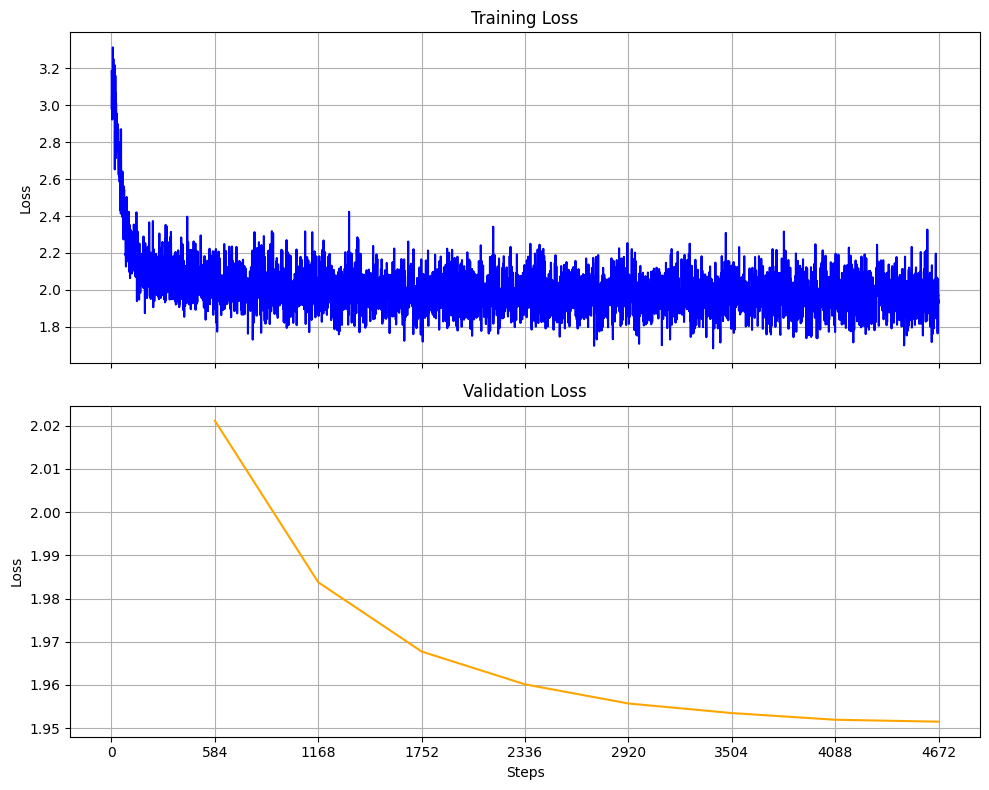

In [1]:
import json
import matplotlib.pyplot as plt

# Load the training history
with open('/home/jupyter/Models/llava-v1.5-7b-r32-trainable params 84,574,208/checkpoint-4672/trainer_state.json', 'r') as file:
    trainer_state = json.load(file)

# Extract loss values from the trainer_state
training_steps = []
training_losses = []
validation_steps = []
validation_losses = []

for log_entry in trainer_state['log_history']:
    if 'loss' in log_entry and 'step' in log_entry:  # This is a training loss entry
        training_steps.append(log_entry['step'])
        training_losses.append(log_entry['loss'])
    elif 'eval_loss' in log_entry and 'step' in log_entry:  # This is a validation loss entry
        validation_steps.append(log_entry['step'])
        validation_losses.append(log_entry['eval_loss'])

# Set up the plot
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot training loss
ax[0].plot(training_steps, training_losses, label='Training Loss', color='blue')
ax[0].set_title('Training Loss')
ax[0].set_ylabel('Loss')
ax[0].grid(True)

# Plot validation loss
ax[1].plot(validation_steps, validation_losses, label='Validation Loss', color='orange')
ax[1].set_title('Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Steps')
ax[1].grid(True)

# Define the tick values as multiples of 1095, considering the range of your steps
tick_step = 584
xticks = range(0, max(max(training_steps, default=0), max(validation_steps, default=0)) + tick_step, tick_step)
ax[1].set_xticks(xticks)  # Set x-ticks on both subplots

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


### Loading the checkpoint after training

In [29]:
# import math

# config = LoraConfig(
#     r=32,
#     lora_alpha = 32 * math.sqrt(32), # this will set the rescaled learning rate to LR * alpha / sqrt (r), with r the rank.
#     target_modules=[
#         "q_proj", "k_proj", "v_proj", # attention mechanisms
#         "fc1", "fc2", #for llama,
#         "mm_projector.0", #for mistral, train instead "mm_projector" - Adapt the multimodal projection layer for better visual-textual alignment
#         "mm_projector.2",
#         "up_proj", "down_proj","gate_proj" #Adapt MLP components within transformer blocks, optionally train more linear layers
#         #"lm_head",  # Adapt the output projection layer that maps to vocabulary
#         ],
#     lora_dropout=0.05,
#     bias="none",
# )
# model = get_peft_model(model, config)

In [30]:
# # List to hold the names of the trainable parameters
# set_other_trainable=True

# if set_other_trainable:
#     trainable_params_names = ['lm_head','embed_tokens']
#     # trainable_params_names = None
    
#     # Set modules to be trainable
#     for n, p in model.named_parameters():
#         if any(k in n for k in trainable_params_names):
#             p.requires_grad_(True)
#         # else:
#         #     p.requires_grad_(False)  # Optional: Set the rest to be not trainable
    
#     # Make a dictionary of trainable parameters
#     trainable_params = {n: p for n, p in model.named_parameters() if p.requires_grad}
    
#     # Convert trainable_params to state_dict format
#     trainable_params_state_dict = {n: p.data for n, p in trainable_params.items()}

In [32]:
# OPTIONALLY LOAD A DIFFERENT CHECKPOINT

from peft import PeftModel

adapter_path="/home/jupyter/Models/llava-v1.6-vicuna-7b-latest-Vicuna/checkpoint-4384" #this is the path to the checkpoint to load

## You have a choice now between either A or B:
# A: Unload the current adapter (if this fails, just run option B to load the base model again).
# model.unload()

# B: Re-load the base model
# the variables required to load the base model should already be declared at the top of this script.
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=None,
    model_name=model_name,
    cache_dir='',
    use_flash_attn=True,
    # load_8bit=True #NOT SUPPORTED YET WITH THIS SCRIPT
    # load_4bit=True #NOT SUPPORTED YET WITH THIS SCRIPT
)

# Now you can load the new model on top.
model = PeftModel.from_pretrained(
    model,
    adapter_path,
)

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

vision_tower is loaded


In [24]:
print(model)

PeftModel(
  (base_model): LoraModel(
    (model): LlavaLlamaForCausalLM(
      (model): LlavaLlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=0)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear(
                (base_layer): Linea

## Eval after Training

##### Displaying predicted Caption

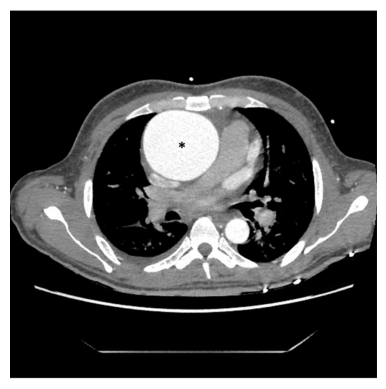

Prompt: A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>
Can you generate caption based on what you see in the image? ASSISTANT:
<s> "A chest X-ray reveals a large mass in the center of the chest, with a star-like shape, possibly indicating a foreign object or a tumor."</s>

Correct caption: CT chest axial view showing a huge ascending aortic aneurysm (*).




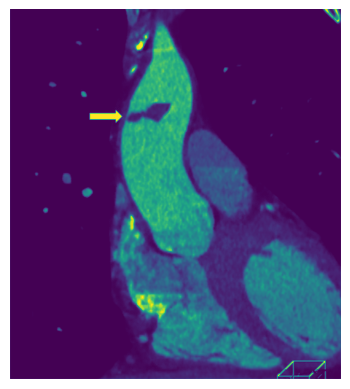

Prompt: A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>
Can you generate caption based on what you see in the image? ASSISTANT:
<s> "Anatomical view of a human heart, highlighting the aortic arch and the left ventricle."</s>

Correct caption: Computed tomography (CT) shows floating thrombosis (white arrow)




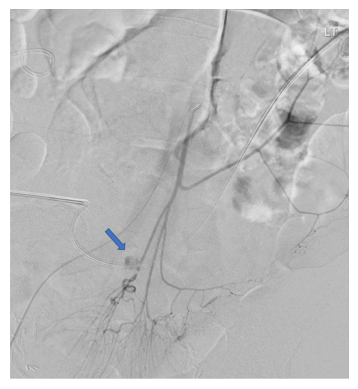

Prompt: A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>
Can you generate caption based on what you see in the image? ASSISTANT:
<s> "Identifying a specific area of interest in a complex medical image using a blue arrow for guidance."</s>

Correct caption: Digitally subtracted angiogram demonstrates active extravasation of the superior rectal artery into the ileal-conduit (blue arrow)




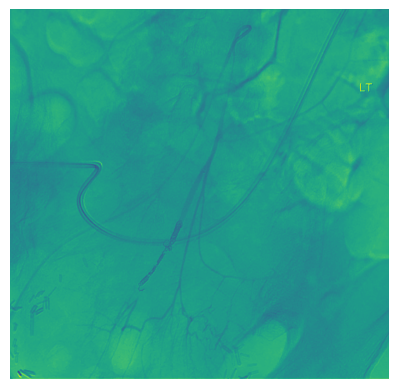

Prompt: A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>
Can you generate caption based on what you see in the image? ASSISTANT:
<s> "Microscopic view of a complex network of blood vessels, highlighting the intricate architecture of the circulatory system."</s>

Correct caption: Digitally subtracted angiogram of the IMA demonstrated cessation of flow through the proximal superior rectal artery in the region of the intersection between the artery and ureter with retained perfusion of the rectosigmoid region and resolution of active extravasation




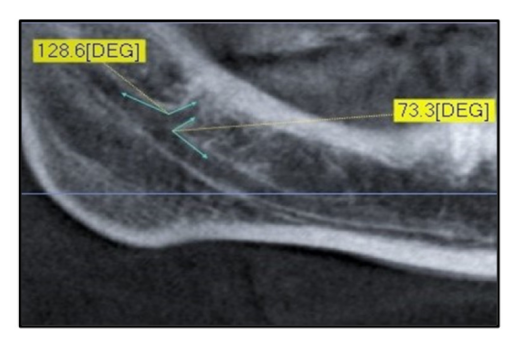

Prompt: A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>
Can you generate caption based on what you see in the image? ASSISTANT:
<s> "Identifying a potential fracture in a bone scan image."</s>

Correct caption: Angle measurement of a Type 1 canal.




In [48]:
import matplotlib.pyplot as plt

# Temporarily disable the transformation to access the original data
eval_ds.reset_format()

# Limit the number of images to process
num_images_to_process = 5

# Iterate over each example in the evaluation dataset, but only up to num_images_to_process
for i in range(min(num_images_to_process, len(eval_ds))):
    # Access the original image and caption for the current row
    image = eval_ds[i]['image']
    caption = eval_ds[i]['caption']

    # Display the image using matplotlib
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

    # Evaluate the model for the given image
    eval_model(
        tokenizer,
        model,
        image_processor,
        context_len,
        image,
        "Can you generate caption based on what you see in the image?"
    )

    # Print the correct caption
    print(f"\nCorrect caption: {caption}\n\n")

# Re-enable the transformation if needed
eval_ds.set_transform(lambda batch: tokenize_and_create_labels(batch, image_processor, tokenizer, model, device))


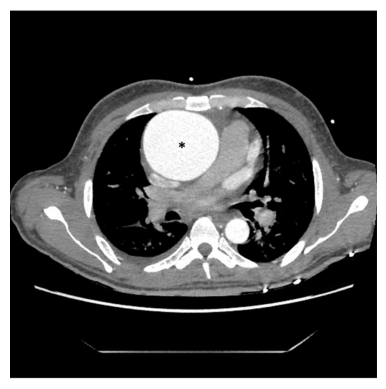


Correct caption: CT chest axial view showing a huge ascending aortic aneurysm (*).




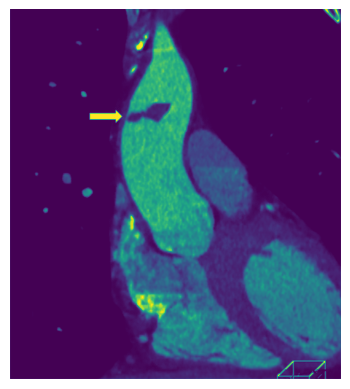


Correct caption: Computed tomography (CT) shows floating thrombosis (white arrow)




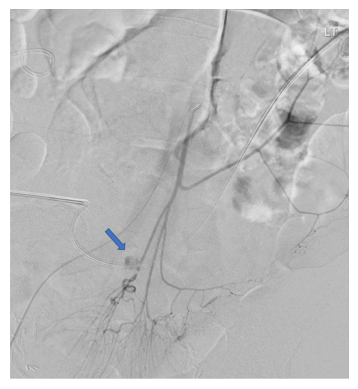


Correct caption: Digitally subtracted angiogram demonstrates active extravasation of the superior rectal artery into the ileal-conduit (blue arrow)




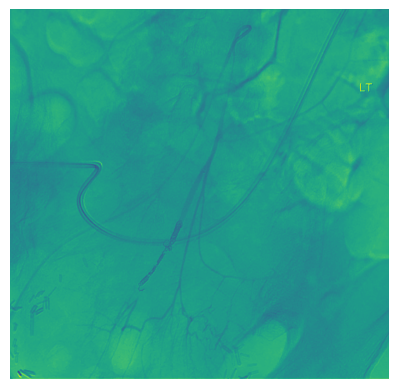


Correct caption: Digitally subtracted angiogram of the IMA demonstrated cessation of flow through the proximal superior rectal artery in the region of the intersection between the artery and ureter with retained perfusion of the rectosigmoid region and resolution of active extravasation




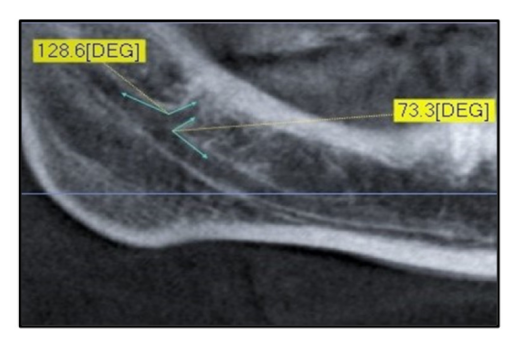


Correct caption: Angle measurement of a Type 1 canal.




In [45]:
import matplotlib.pyplot as plt

# Temporarily disable the transformation to access the original data
eval_ds.reset_format()

# Limit the number of images to process
num_images_to_process = 5

# Iterate over each example in the evaluation dataset, but only up to num_images_to_process
for i in range(min(num_images_to_process, len(eval_ds))):
    # Access the original image and caption for the current row
    image = eval_ds[i]['image']
    caption = eval_ds[i]['caption']

    # Display the image using matplotlib
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

    # Evaluate the model for the given image
    eval_model(
        tokenizer,
        model,
        image_processor,
        context_len,
        image,
        "What do you see in this picture?"
    )

    # Print the correct caption
    print(f"\nCorrect caption: {caption}\n\n")

# Re-enable the transformation if needed
eval_ds.set_transform(lambda batch: tokenize_and_create_labels(batch, image_processor, tokenizer, model, device))


## Evaluation Metrics Bertscore and Rogue

In [39]:
# import pandas as pd
# from bert_score import score as bert_score
# from rouge import Rouge

# def compute_overall_metrics(true_captions, predicted_captions):
#     # Initialize Rouge and prepare to compute overall scores
#     rouge = Rouge()
#     overall_scores = {}

#     # Compute overall ROUGE scores
#     try:
#         rouge_result = rouge.get_scores(predicted_captions, true_captions, avg=True)
#         overall_scores['rouge-1'] = rouge_result['rouge-1']['f']
#         overall_scores['rouge-2'] = rouge_result['rouge-2']['f']
#         overall_scores['rouge-l'] = rouge_result['rouge-l']['f']
#     except Exception as e:
#         print("Failed to compute Rouge:", e)
#         overall_scores['rouge-1'] = None
#         overall_scores['rouge-2'] = None
#         overall_scores['rouge-l'] = None

#     # Compute overall BERTScore
#     try:
#         P, R, F1 = bert_score(predicted_captions, true_captions, lang="en", verbose=False)
#         overall_scores['bertscore'] = F1.mean().item()
#     except Exception as e:
#         print("Failed to compute BertScore:", e)
#         overall_scores['bertscore'] = None

#     return overall_scores

# # Create lists to store individual captions
# correct_captions = []
# predicted_captions = []

# # Temporarily disable the transformation to access the original data
# eval_ds.reset_format()

# # Iterate over each example in the evaluation dataset
# for i in range(len(eval_ds)):
#     # Access the original image and correct caption for the current row
#     image = eval_ds[i]['image']
#     correct_caption = eval_ds[i]['caption']

#     # Evaluate the model for the given image to generate a predicted caption
#     predicted_caption = eval_model(
#         tokenizer,
#         model,
#         image_processor,
#         context_len,
#         image,
#         "What do you see in this picture?"
#     )

#     # Store captions for overall metrics calculation
#     correct_captions.append(correct_caption)
#     predicted_captions.append(predicted_caption)

# # Compute overall metrics for all captions
# overall_metrics = compute_overall_metrics(correct_captions, predicted_captions)

# # Create a DataFrame from the overall metrics
# df_overall_metrics = pd.DataFrame([overall_metrics])

# # Display the DataFrame to verify the contents
# print(df_overall_metrics)

# # Optionally, save the DataFrame to a CSV file
# # df_overall_metrics.to_csv('/home/jupyter/overall_captions_metrics.csv', index=False)

# # Re-enable the transformation if needed
# eval_ds.set_transform(lambda batch: tokenize_and_create_labels(batch, image_processor, tokenizer, model, device))


## Generating CSV from test dataset

In [ ]:
# Example usage with a dataset
ds_test = load_dataset("HoqueMahmudul/test_dataset")

test_ds = ds_test['test']

In [47]:
captions[9]

('ImageCLEFmedical_Caption_2024_test_000010.jpg',
 'Computed tomography scan of the chest showing a 4.5 cm × 3.5 cm × 4.5 cm mass in the right atrium.')

In [39]:
for i in range(len(captions)):
    print(captions[i])

('ImageCLEFmedical_Caption_2024_test_000001.jpg', 'Fluoroscopic image of the patient’s esophagus. The yellow arrows indicate the location of the esophageal stricture. The white arrows indicate the location of the esophageal diverticulum.')
('ImageCLEFmedical_Caption_2024_test_000002.jpg', 'Fluoroscopic image of the right upper quadrant showing the needle (yellow arrow) in the gallbladder (white arrow) and the tip of the guidewire (white arrowhead) in the duodenum.')
('ImageCLEFmedical_Caption_2024_test_000003.jpg', 'Endoscopic retrograde cholangiopancreatography (ERCP) showing a filling defect in the common bile duct.')
('ImageCLEFmedical_Caption_2024_test_000004.jpg', 'ERCP showing a dilated common bile duct with a filling defect.')
('ImageCLEFmedical_Caption_2024_test_000005.jpg', 'Sagittal T2-weighted MRI of the lumbar spine showing a large, well-defined, hyperintense lesion at the L2-L3 level.')
('ImageCLEFmedical_Caption_2024_test_000006.jpg', 'Transthoracic echocardiogram showing

In [29]:
captions[2]

('ImageCLEFmedical_Caption_2024_test_000003.jpg',
 'Postoperative esophagogram showing the esophagus and the gastric tube in the right thoracic cavity.')

In [ ]:
# Accessing items one by one using test_ds[i] can be inefficient, especially for larger datasets. 
# If performance is an issue, consider batch processing if your model and infrastructure support it.


# Now iterate through the test dataset to generate captions
captions = []

# Temporarily disable the transformation to access the original data
test_ds.reset_format()

for i in range(len(test_ds)):
    # Access the original image and image name for the current row
    image = test_ds[i]['image']
    image_name = test_ds[i]['image_name']
    
    # Evaluate the model for the given image to generate a predicted caption using eval_model function
    predicted_caption = eval_model(
        tokenizer,
        model,
        image_processor,
        context_len,
        image,
        "What do you see in this picture?"
    )
    
    # Append the correct and predicted captions as a tuple to the captions list
    captions.append((image_name, predicted_caption))

# Create a DataFrame from the captions list with the specified column titles
df_captions_generation_test = pd.DataFrame(captions, columns=['ID', 'predicted_caption'])

# Display the DataFrame to verify the contents
print(df_captions_generation_test)

# Optionally, save the DataFrame to a CSV file
df_captions_generation_test.to_csv('/home/jupyter/Test dataset caption/llava-1.5v-r32-trainable params 84,574,208-usual-prompt.csv', index=False)

# Re-enable the transformation if needed
test_ds.set_transform(lambda batch: tokenize_and_create_labels(batch, image_processor, tokenizer, model, device))

                                                  ID  \
0      ImageCLEFmedical_Caption_2024_test_000001.jpg   
1      ImageCLEFmedical_Caption_2024_test_000002.jpg   
2      ImageCLEFmedical_Caption_2024_test_000003.jpg   
3      ImageCLEFmedical_Caption_2024_test_000004.jpg   
4      ImageCLEFmedical_Caption_2024_test_000005.jpg   
...                                              ...   
17232  ImageCLEFmedical_Caption_2024_test_017260.jpg   
17233  ImageCLEFmedical_Caption_2024_test_017261.jpg   
17234  ImageCLEFmedical_Caption_2024_test_017262.jpg   
17235  ImageCLEFmedical_Caption_2024_test_017263.jpg   
17236  ImageCLEFmedical_Caption_2024_test_017264.jpg   

                                       predicted_caption  
0      CT scan of the abdomen and pelvis showing a la...  
1      The image shows the position of the needle in ...  
2      Postoperative CT scan showing the stent in the...  
3      A 20-French endoscopic retrograde cholangiopan...  
4      MRI of the lumbar spine s

# Finish

In [ ]:
print('h')

In [57]:
from llava.model.language_model.llava_mistral import LlavaMistralForCausalLM
from peft import LoraConfig, get_peft_model

In [59]:
# # Initialize the base model
# base_model_x = LlavaMistralForCausalLM.from_pretrained("liuhaotian/llava-v1.6-mistral-7b")

# # Apply LoRA modifications to the base model
# config = LoraConfig(
#     r=16,
#     lora_alpha=32,
#     target_modules=[
#         "q_proj", "k_proj", "v_proj",
#         "mm_projector",
#         "up_proj", "down_proj", "gate_proj"
#     ],
#     lora_dropout=0.05,
#     bias="none",
# )
# lora_model_x = get_peft_model(base_model_x, config)

In [72]:
best_checkpoint_path = "/home/jupyter/Models/llava-v1.6-mistral-7b-600-images/checkpoint-30/adapter_model.safetensors"


In [40]:
# model = torch.load(best_checkpoint_path)

In [41]:
# checkpoint = torch.load(best_checkpoint_path, map_location=torch.device)
# model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
from transformers import Trainer, TrainingArguments

# Load the model
model.load_state_dict(torch.load('path/to/checkpoint-XX/adapter_model.pth'))

# Load the optimizer and scheduler state
optimizer.load_state_dict(torch.load('path/to/checkpoint-XX/optimizer.pt'))
scheduler.load_state_dict(torch.load('path/to/checkpoint-XX/scheduler.pt'))

# Continue training
training_args = TrainingArguments(
    # Set up your training arguments, possibly loading from training_args.bin
)
trainer = Trainer(
    model=model,
    args=training_args,
    # Specify additional Trainer setup
)

trainer.train(resume_from_checkpoint=True)


In [45]:
# checkpoint = torch.load(best_checkpoint_path, map_location=lambda storage, loc: storage.cuda() if torch.cuda.is_available() else storage)

# # Load the checkpoint into your model
# model.load_state_dict(checkpoint['model_state_dict'])

In [43]:
# # OR,
# # Load the best checkpoint into the LoRA-adapted model
# loading_model = model.load_state_dict(torch.load(best_checkpoint_path))


In [ ]:
# Define your model architecture here
model = YourModelArchitecture(...)


In [51]:
best_checkpoint_path = "/home/jupyter/Models/llava-v1.6-mistral-7b-600-images/checkpoint-30"

In [ ]:
# # If you have a CUDA-enabled GPU
# checkpoint = torch.load(best_checkpoint_path, map_location=torch.device('cuda'))


In [ ]:
import torch

# Automatically use CUDA if available
checkpoint = torch.load(best_checkpoint_path, map_location=lambda storage, loc: storage.cuda() if torch.cuda.is_available() else storage)


In [ ]:
# Load the checkpoint into your model
model.load_state_dict(checkpoint['model_state_dict'])

In [44]:
# model = LlavaMistralForCausalLM.from_pretrained(best_checkpoint_path)

In [ ]:
# from LLaVA.llava.model.language_model.llava_mistral import LlavaMistralForCausalLM

# best_checkpoint_path = "path/to/your/best/checkpoint"  # Update this path with your actual best checkpoint path
# model = LlavaMistralForCausalLM.from_pretrained(best_checkpoint_path)



### generating csv over test set or eval set

In [49]:
import pandas as pd

# Create an empty list to store both correct and predicted captions
captions = []

# Temporarily disable the transformation to access the original data
eval_ds.reset_format()

# # Example evaluation loop can use enumerate as well
# for i, data in enumerate(eval_ds):
#     # Prepare your data here
#     # For example, for an image captioning task:
#     image = data['image']
#     true_caption = data['caption']

# Iterate over each example in the evaluation dataset
for i in range(len(eval_ds)):
    # Access the original image and correct caption for the current row
    image = eval_ds[i]['image']
    correct_caption = eval_ds[i]['caption']

    # Evaluate the model for the given image to generate a predicted caption using eval_model function
    predicted_caption = eval_model(
        tokenizer,
        model,
        image_processor,
        context_len,
        image,
        "What do you see in this picture?"
    )

    # Append the correct and predicted captions as a tuple to the captions list
    captions.append((correct_caption, predicted_caption))

# Create a DataFrame from the captions list with the specified column titles
df_captions = pd.DataFrame(captions, columns=['correct_caption', 'predicted_caption'])

# Display the DataFrame to verify the contents
print(df_captions)

# Optionally, save the DataFrame to a CSV file
df_captions.to_csv('/home/jupyter/captions_comparison.csv', index=False)

# Re-enable the transformation if needed
eval_ds.set_transform(lambda batch: tokenize_and_create_labels(batch, image_processor, tokenizer, model, device))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

                                      correct_caption  \
0   Transabdominal ultrasonography of right lower ...   
1   Ultrasonographic examination of an embryo vesi...   
2   Chest x-ray demonstrating bilateral calcificat...   
3   Transvaginal ultrasonography shows a septate c...   
4                    Showing deployed Sapien 3 valve.   
..                                                ...   
95  Ultrasonography (sagittal view) showing an inc...   
96   Intraoperative fluoroscopy showing positionin...   
97  Computerized tomography scan of the brain in t...   
98  Pulmonary blastomycosis chest X-ray image. Che...   
99  X-ray image of aseptic loosening of the distal...   

                                    predicted_caption  
0   Transabdominal ultrasound showing the presence...  
1   Transverse section of the fetal head at 32 wee...  
2     Chest X-ray showing bilateral pleural effusion.  
3   Transvaginal ultrasound image of the uterus an...  
4   Chest radiograph of a patient w

In [37]:
# Print the keys of the first item in the dataset
if len(eval_ds) > 0:
    first_item_keys = eval_ds[0].keys()
    print("Available fields in the first item of eval_ds:", first_item_keys)
else:
    print("The dataset is empty.")


Available fields in the first item of eval_ds: dict_keys(['image', 'caption'])


In [36]:
# Print the first 3 items in the dataset
for i in range(min(3, len(eval_ds))):
    print(f"Item {i}:")
    for key in eval_ds[i].keys():
        value = eval_ds[i][key]
        # Since some values can be very large (like tensors), we print their type and size instead of the values themselves
        if hasattr(value, 'shape'):  # Check if the value is a tensor or similar
            print(f"  {key}: {type(value)} with shape {value.shape}")
        else:
            print(f"  {key}: {value}")
    print("\n")


Item 0:
  image: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=680x459 at 0x7F47FDC27B60>
  caption: Transabdominal ultrasonography of right lower quadrant revealed an inhomogeneous hypoechoic mass above the urinary bladder.


Item 1:
  image: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=770x594 at 0x7F47FDC27C50>
  caption: Ultrasonographic examination of an embryo vesicle. Placenta is marked with “P”, allantoic sac with “AL”, amniotic sac with “*”, fetus with “F” and umbilical cord with “U”.


Item 2:
  image: <PIL.JpegImagePlugin.JpegImageFile image mode=L size=693x591 at 0x7F47FDC275C0>
  caption: Chest x-ray demonstrating bilateral calcifications and interstitial changes on initial workup.




In [ ]:
# Optionally, save the DataFrame to a CSV file
df_predictions.to_csv('/home/jupyter/predicted_captions.csv', index=False)

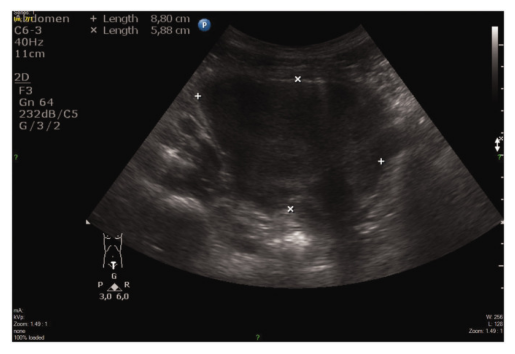

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: [INST] <image>
What do you see in this picture? [/INST]
<s> Transabdominal ultrasound showing the presence of a 3.0 cm hypoechoic mass in the right adrenal gland. </s>

Correct caption: Transabdominal ultrasonography of right lower quadrant revealed an inhomogeneous hypoechoic mass above the urinary bladder.




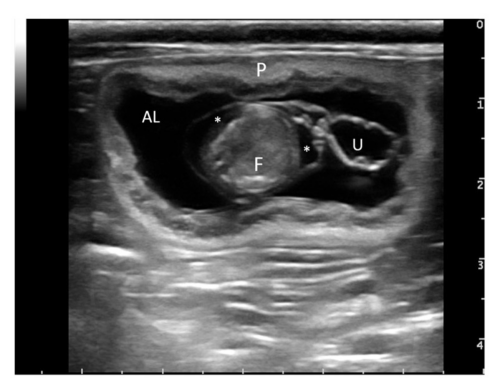

Prompt: [INST] <image>
What do you see in this picture? [/INST]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> Transverse section of the fetal head at 32 weeks of gestation. </s>

Correct caption: Ultrasonographic examination of an embryo vesicle. Placenta is marked with “P”, allantoic sac with “AL”, amniotic sac with “*”, fetus with “F” and umbilical cord with “U”.




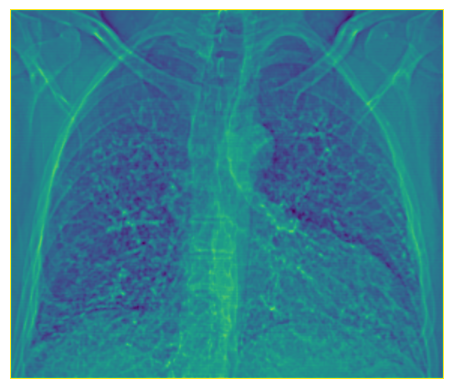

Prompt: [INST] <image>
What do you see in this picture? [/INST]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> Chest X-ray showing bilateral pleural effusion. </s>

Correct caption: Chest x-ray demonstrating bilateral calcifications and interstitial changes on initial workup.




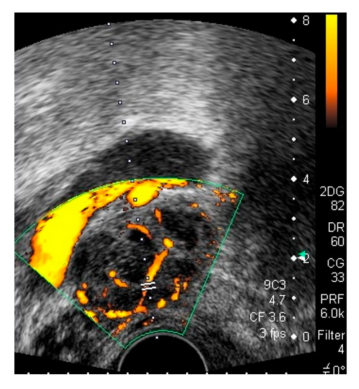

Prompt: [INST] <image>
What do you see in this picture? [/INST]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> Transvaginal ultrasound image of the uterus and ovaries. </s>

Correct caption: Transvaginal ultrasonography shows a septate cystic nodule independent from ovary corresponding to ovarian vein thrombosis. Power Doppler demonstrates peripheral and central vascularization.




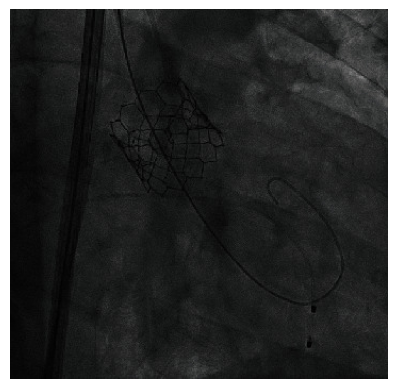

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: [INST] <image>
What do you see in this picture? [/INST]
<s> Chest radiograph of a patient with COVID-19 pneumonia. </s>

Correct caption: Showing deployed Sapien 3 valve.




In [41]:
import matplotlib.pyplot as plt

# Temporarily disable the transformation to access the original data
eval_ds.reset_format()

# Limit the number of images to process
num_images_to_process = 5

# Iterate over each example in the evaluation dataset, but only up to num_images_to_process
for i in range(min(num_images_to_process, len(eval_ds))):
    # Access the original image and caption for the current row
    image = eval_ds[i]['image']
    caption = eval_ds[i]['caption']

    # Display the image using matplotlib
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

    # Evaluate the model for the given image
    eval_model(
        tokenizer,
        model,
        image_processor,
        context_len,
        image,
        "What do you see in this picture?"
    )

    # Print the correct caption
    print(f"\nCorrect caption: {caption}\n\n")

# Re-enable the transformation if needed
eval_ds.set_transform(lambda batch: tokenize_and_create_labels(batch, image_processor, tokenizer, model, device))


In [1]:
# import matplotlib.pyplot as plt

# # Temporarily disable the transformation to access the original data
# eval_ds.reset_format()

# # Limit the number of images to process
# num_images_to_process = 5

# # Iterate over each example in the evaluation dataset, but only up to num_images_to_process
# for i in range(min(num_images_to_process, len(eval_ds))):
#     # Access the original image and caption for the current row
#     image = eval_ds[i]['image']
#     caption = eval_ds[i]['caption']

#     # Display the image using matplotlib
#     plt.imshow(image)
#     plt.axis('off')  # Turn off axis numbers and ticks
#     plt.show()

#     # Evaluate the model for the given image
#     eval_model(
#         tokenizer,
#         model,
#         image_processor,
#         context_len,
#         image,
#         "What do you see in this picture?"
#     )

#     # Print the correct caption
#     print(f"\nCorrect caption: {caption}\n\n")

# # Re-enable the transformation if needed
# eval_ds.set_transform(lambda batch: tokenize_and_create_labels(batch, image_processor, tokenizer, model, device))


NameError: name 'eval_ds' is not defined

# Push your new model to the hub!


In [88]:
# Required when quantizing models/data that are gated on HuggingFace, and required for pushing models to HuggingFace.
!pip install huggingface_hub -q -U
from huggingface_hub import notebook_login

notebook_login()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [89]:
model=model.merge_and_unload()

In [91]:
tokenizer.push_to_hub(f"HoqueMahmudul/{output_model_name}", private=True)

  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/HoqueMahmudul/llava-v1.6-mistral-7b-chess/commit/17c30c2b37bae2e0fb7b76f48e77fb80a7a51b04', commit_message='Upload tokenizer', commit_description='', oid='17c30c2b37bae2e0fb7b76f48e77fb80a7a51b04', pr_url=None, pr_revision=None, pr_num=None)

## Upload folder method

In [93]:
from huggingface_hub import HfApi, upload_folder

# Initialize the HfApi class
api = HfApi()

# Specify the local folder path you want to upload
folder_path = output_model_name

target_repo = "HoqueMahmudul/llava-v1.6-mistral-7b-chess"

# # Optionally, create a new branch for 'awq'. Beware this will copy all files from main.
# create_branch(repo_id, repo_type="model", branch="awq")

# Upload the entire folder to the specified branch in the repository
upload_folder(
    folder_path=folder_path,
    repo_id=target_repo,
    repo_type="model",  # Assuming it's a model; can be "dataset" or "space" as well
    # revision="awq",  # Specify the branch you want to push to
    token=True,
    commit_message='Pushed patched model'
)

print(f"Uploaded contents of {folder_path} to {target_repo}")

  0%|          | 0/10 [00:00<?, ?it/s]

checkpoint-30/adapter_model.safetensors:   0%|          | 0.00/61.4M [00:00<?, ?B/s]

checkpoint-30/optimizer.pt:   0%|          | 0.00/114M [00:00<?, ?B/s]

checkpoint-30/rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

checkpoint-30/scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

checkpoint-75/training_args.bin:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

checkpoint-75/adapter_model.safetensors:   0%|          | 0.00/61.4M [00:00<?, ?B/s]

checkpoint-75/optimizer.pt:   0%|          | 0.00/114M [00:00<?, ?B/s]

checkpoint-75/rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

checkpoint-75/scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

checkpoint-75/training_args.bin:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

Uploaded contents of llava-v1.6-mistral-7b-chess to HoqueMahmudul/llava-v1.6-mistral-7b-chess


In [4]:
pwd()

'/home/jupyter'

In [ ]:
# from llava.model.language_model.llava_mistral import LlavaMistralForCausalLM

# best_checkpoint_path = "path/to/your/best/checkpoint"  # Update this with the actual path
# model = LlavaMistralForCausalLM.from_pretrained(best_checkpoint_path)


In [9]:
# Assuming 'best_checkpoint_path' contains the path to your best checkpoint
best_checkpoint_path = "llava-v1.6-mistral-7b-chess"

# Load the model from the best checkpoint
model = LlavaMistralForCausalLM.from_pretrained(best_checkpoint_path)

NameError: name 'LlavaMistralForCausalLM' is not defined